In [1]:
# General Imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Astronomy Specific Imports
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits

# Image Analysis Specific Imports
from skimage.measure import perimeter, euler_number

import porespy as ps
ps.visualization.set_mpl_style()

def remove_region(data, wcs, longitude_min, longitude_max, latitude_min, latitude_max):
    
    min_coord_remove = SkyCoord(longitude_min, latitude_min, frame='galactic', unit=u.deg)
    max_coord_remove = SkyCoord(longitude_max, latitude_max, frame='galactic', unit=u.deg)

    min_pixel_remove = wcs[:][:][0].world_to_pixel(min_coord_remove)
    max_pixel_remove = wcs[:][:][0].world_to_pixel(max_coord_remove)

    # Create a mask based on these galactic coordinates
    remove_mask = np.zeros(data.shape, dtype=bool)

    # Set True in the mask for the specified region based on pixel indices
    y_min, x_min = int(np.floor(min_pixel_remove[1])), int(np.floor(min_pixel_remove[0]))
    y_max, x_max = int(np.ceil(max_pixel_remove[1])), int(np.ceil(max_pixel_remove[0]))

    # Apply the mask to the region within the pixel boundaries
    remove_mask[y_min:y_max, x_max:x_min] = True
    
    # Apply the mask to the original data to set the region to NaN or another value
    data[remove_mask] = np.nan  # Replace with np.nan to exclude the data

    return data

def derive_density_maps():
    # Get the current working directory
    curr_folder = os.getcwd()

    # Find the index of 'notebooks' in the current path
    notebooks_index = curr_folder.rfind('notebooks')

    # Check if 'notebooks' is found in the path
    if notebooks_index != -1:
        # Set the directory to the parent of 'notebooks'
        src_path = os.path.dirname(curr_folder[:notebooks_index])
        os.chdir(src_path)  # Change the current working directory to the source path
        sys.path.insert(0, src_path)  # Insert the source path into sys.path for module imports

    # Construct the path to the FITS file
    planck_herschel_fits_file = os.path.join(curr_folder, "Lombardi", "planck_herschel.fits.gz")

    hdu_herschel_fits = fits.open(planck_herschel_fits_file)[0]
    
    # Constructt WCS and image data
    wcs = WCS(hdu_herschel_fits.header)

    image_data = hdu_herschel_fits.data[0]

    # Replace NaNs and Infs with some valid value, e.g., zero or the median
    tau = np.nan_to_num(image_data, nan=0.0, posinf=0.0, neginf=0.0)

    # Step 1: Define constants
    # TO-DO: differentiate between Orion A and B 

    # Orion A: 206 ≤ l ≤ 217, −21 ≤ b ≤ −17
    # Orion B: 203 ≤ l ≤ 210, −17 ≤ b ≤ −12

    # Step 3: Apply the formula to calculate A_k (Lomabrdi et al)
    l_min_A, l_max_A = 206, 217
    b_min_A, b_max_A = -21, -17

    # Making it smaller cause of computation time
    # l_min_A, l_max_A = 210, 212
    # b_min_A, b_max_A = -21, -20

    min_coord_A = SkyCoord(l_min_A, b_min_A, frame='galactic', unit=u.deg)
    max_coord_A = SkyCoord(l_max_A, b_max_A, frame='galactic', unit=u.deg)

    min_pixel_A = wcs[:][:][0].world_to_pixel(min_coord_A)
    max_pixel_A = wcs[:][:][0].world_to_pixel(max_coord_A)

    gamma_orion_A = 2640  # mag
    delta_orion_A = 0.012  # mag, Offset for Orion A

    A_k = gamma_orion_A * tau + delta_orion_A

    A_k[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])] = gamma_orion_A * tau[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])] + delta_orion_A

    l_min_B, l_max_B = 203, 210
    b_min_B, b_max_B = -17, -12

    min_coord_B = SkyCoord(l_min_B, b_min_B, frame='galactic', unit=u.deg)
    max_coord_B = SkyCoord(l_max_B, b_max_B, frame='galactic', unit=u.deg)

    min_pixel_B = wcs[:][:][0].world_to_pixel(min_coord_B)
    max_pixel_B = wcs[:][:][0].world_to_pixel(max_coord_B)

    gamma_orion_B = 3460  # mag
    delta_orion_B = -0.001  # mag, Offset for Orion B

    A_k[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])] = gamma_orion_B * tau[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])] + delta_orion_B

    # A_k to A_V
    A_V = A_k/0.112

    # N(H2)
    N_H2 = 0.93e21 * np.array(A_V , dtype=np.float64)

    # Define regions to remove as a list of dictionaries
    regions_to_remove = [
        # Orion A regions
        {"longitude_min": 208, "longitude_max": 211, "latitude_min": -17.9, "latitude_max": -16.9},
        {"longitude_min": 214.5, "longitude_max": 216.5, "latitude_min": -18, "latitude_max": -17},
        {"longitude_min": 206, "longitude_max": 206.5, "latitude_min": -19.5, "latitude_max": -19},

        # Orion B regions
        {"longitude_min": 208, "longitude_max": 210, "latitude_min": -15, "latitude_max": -12},
        {"longitude_min": 209, "longitude_max": 210, "latitude_min": -16.4, "latitude_max": -15.5},
        {"longitude_min": 203, "longitude_max": 205, "latitude_min": -12.3, "latitude_max": -11.5},
        {"longitude_min": 204.5, "longitude_max": 205.5, "latitude_min": -12.2, "latitude_max": -11.5},
        {"longitude_min": 205.8, "longitude_max": 207, "latitude_min": -13.5, "latitude_max": -12.5},
    ]

    # Loop through each region and remove it from N_H2
    for region in regions_to_remove:
        N_H2 = remove_region(
            N_H2,
            wcs,
            region["longitude_min"],
            region["longitude_max"],
            region["latitude_min"],
            region["latitude_max"]
        )

    
    N_H2_OA = N_H2[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])]
    N_H2_OB = N_H2[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])]

    N_H2 = np.nan_to_num(N_H2, nan=0.0, posinf=0.0, neginf=0.0)
    N_H2_OA = np.nan_to_num(N_H2_OA, nan=0.0, posinf=0.0, neginf=0.0)
    N_H2_OB = np.nan_to_num(N_H2_OB, nan=0.0, posinf=0.0, neginf=0.0)
    
    return N_H2, N_H2_OA, N_H2_OB, wcs

def minkowski_funct(data, region_name="Orion A", threshold_min = 1e20, threshold_max=1e22):

    thresholds = np.logspace(np.log10(threshold_min), np.log10(threshold_max), 100)

    # Store Minkowski Functional values
    areas = []
    perimeters = []
    euler_chars = []

    # Process each threshold
    for threshold in thresholds:
        # Create binary mask
        mask = data >= threshold

        # Compute Area (v0)
        area = np.sum(mask)
        areas.append(area)

        # Compute Perimeter (v1)
        perim = perimeter(mask)
        perimeters.append(perim)

        # Compute the euler characteristic
        # For 2D objects, the Euler number is the number of objects minus the number of holes. 
        euler_char = euler_number(mask)
        euler_chars.append(euler_char)

    # Convert to log scale for fractal dimension analysis
    log_areas = np.log10(areas)
    log_perimeters = np.log10(perimeters)
    
    D = 2*log_perimeters/log_areas # proof in Mandelbrot, Hack
    print("The average fractal dimension using the Perimeter-Area relation", np.mean(D)) # + const kinda ignored
    
    D_2 = (2 + np.log10(np.abs(euler_chars))/(log_areas))  # I am not sure about this one!!
    # D_2 = (3 + )
    print("The average fractal dimension using the v_2-Area relation", np.mean(D_2)) 

    # Plot the results
    plt.figure(figsize=(14, 8))
    plt.suptitle("Minkowski Functionals of "+region_name, fontsize=16)

    plt.subplot(1, 4, 1)
    plt.plot(thresholds, areas, 'o-', label='Area')
    plt.xlabel('Threshold')
    plt.ylabel('Area (v0)')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.plot(thresholds, perimeters, 'o-', label='Perimeter')
    plt.xlabel('Threshold')
    plt.ylabel('Perimeter (v1)')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.plot(log_perimeters, log_areas, 'o-')
    plt.xlabel('log P')
    plt.ylabel('log A')


    plt.subplot(1, 4, 4)
    plt.plot(thresholds, euler_chars, 'o-', label='Euler Characteristic')
    plt.xlabel('Threshold')
    plt.ylabel('Euler Characteristic (v2)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot the scale dependency
    plt.figure(figsize=(14, 8))
    plt.subplot(1, 2, 1)
    plt.plot(thresholds, D, 'o-')
    plt.title("Scale Dependency in "+region_name)
    plt.xlabel('Threshold')
    plt.ylabel('Fractal Dimension')
    plt.xscale("log")

    plt.subplot(1, 2, 2)
    plt.plot(thresholds, D_2, 'o-')
    plt.title("Scale Dependency in "+region_name)
    plt.xlabel('Threshold')
    plt.ylabel('Fractal Dimension')
    plt.xscale("log")

    plt.tight_layout()
    plt.show()

    return D, thresholds, 

    # Kolmogorov turbulence predicts 
    # D = 5/3 (1.7) for turbulent isobar models
    # D = 4/3 (1.3) for turbulent isothermal models

N_H2, N_H2_OA, N_H2_OB, wcs = derive_density_maps()

[13:03:28] ERROR    PARDISO solver not installed, run `pip install pypardiso`. Otherwise,          ]8;id=935223;file://c:\Users\User\anaconda3\envs\Astronomy_Env\Lib\site-packages\openpnm\utils\_workspace.py\_workspace.py]8;;\:]8;id=865997;file://c:\Users\User\anaconda3\envs\Astronomy_Env\Lib\site-packages\openpnm\utils\_workspace.py#56\56]8;;\
                    simulations will be slow. Apple M chips not supported.                                         

The average fractal dimension using the Perimeter-Area relation 1.7181946080395891
The average fractal dimension using the v_2-Area relation 2.4540384386011045


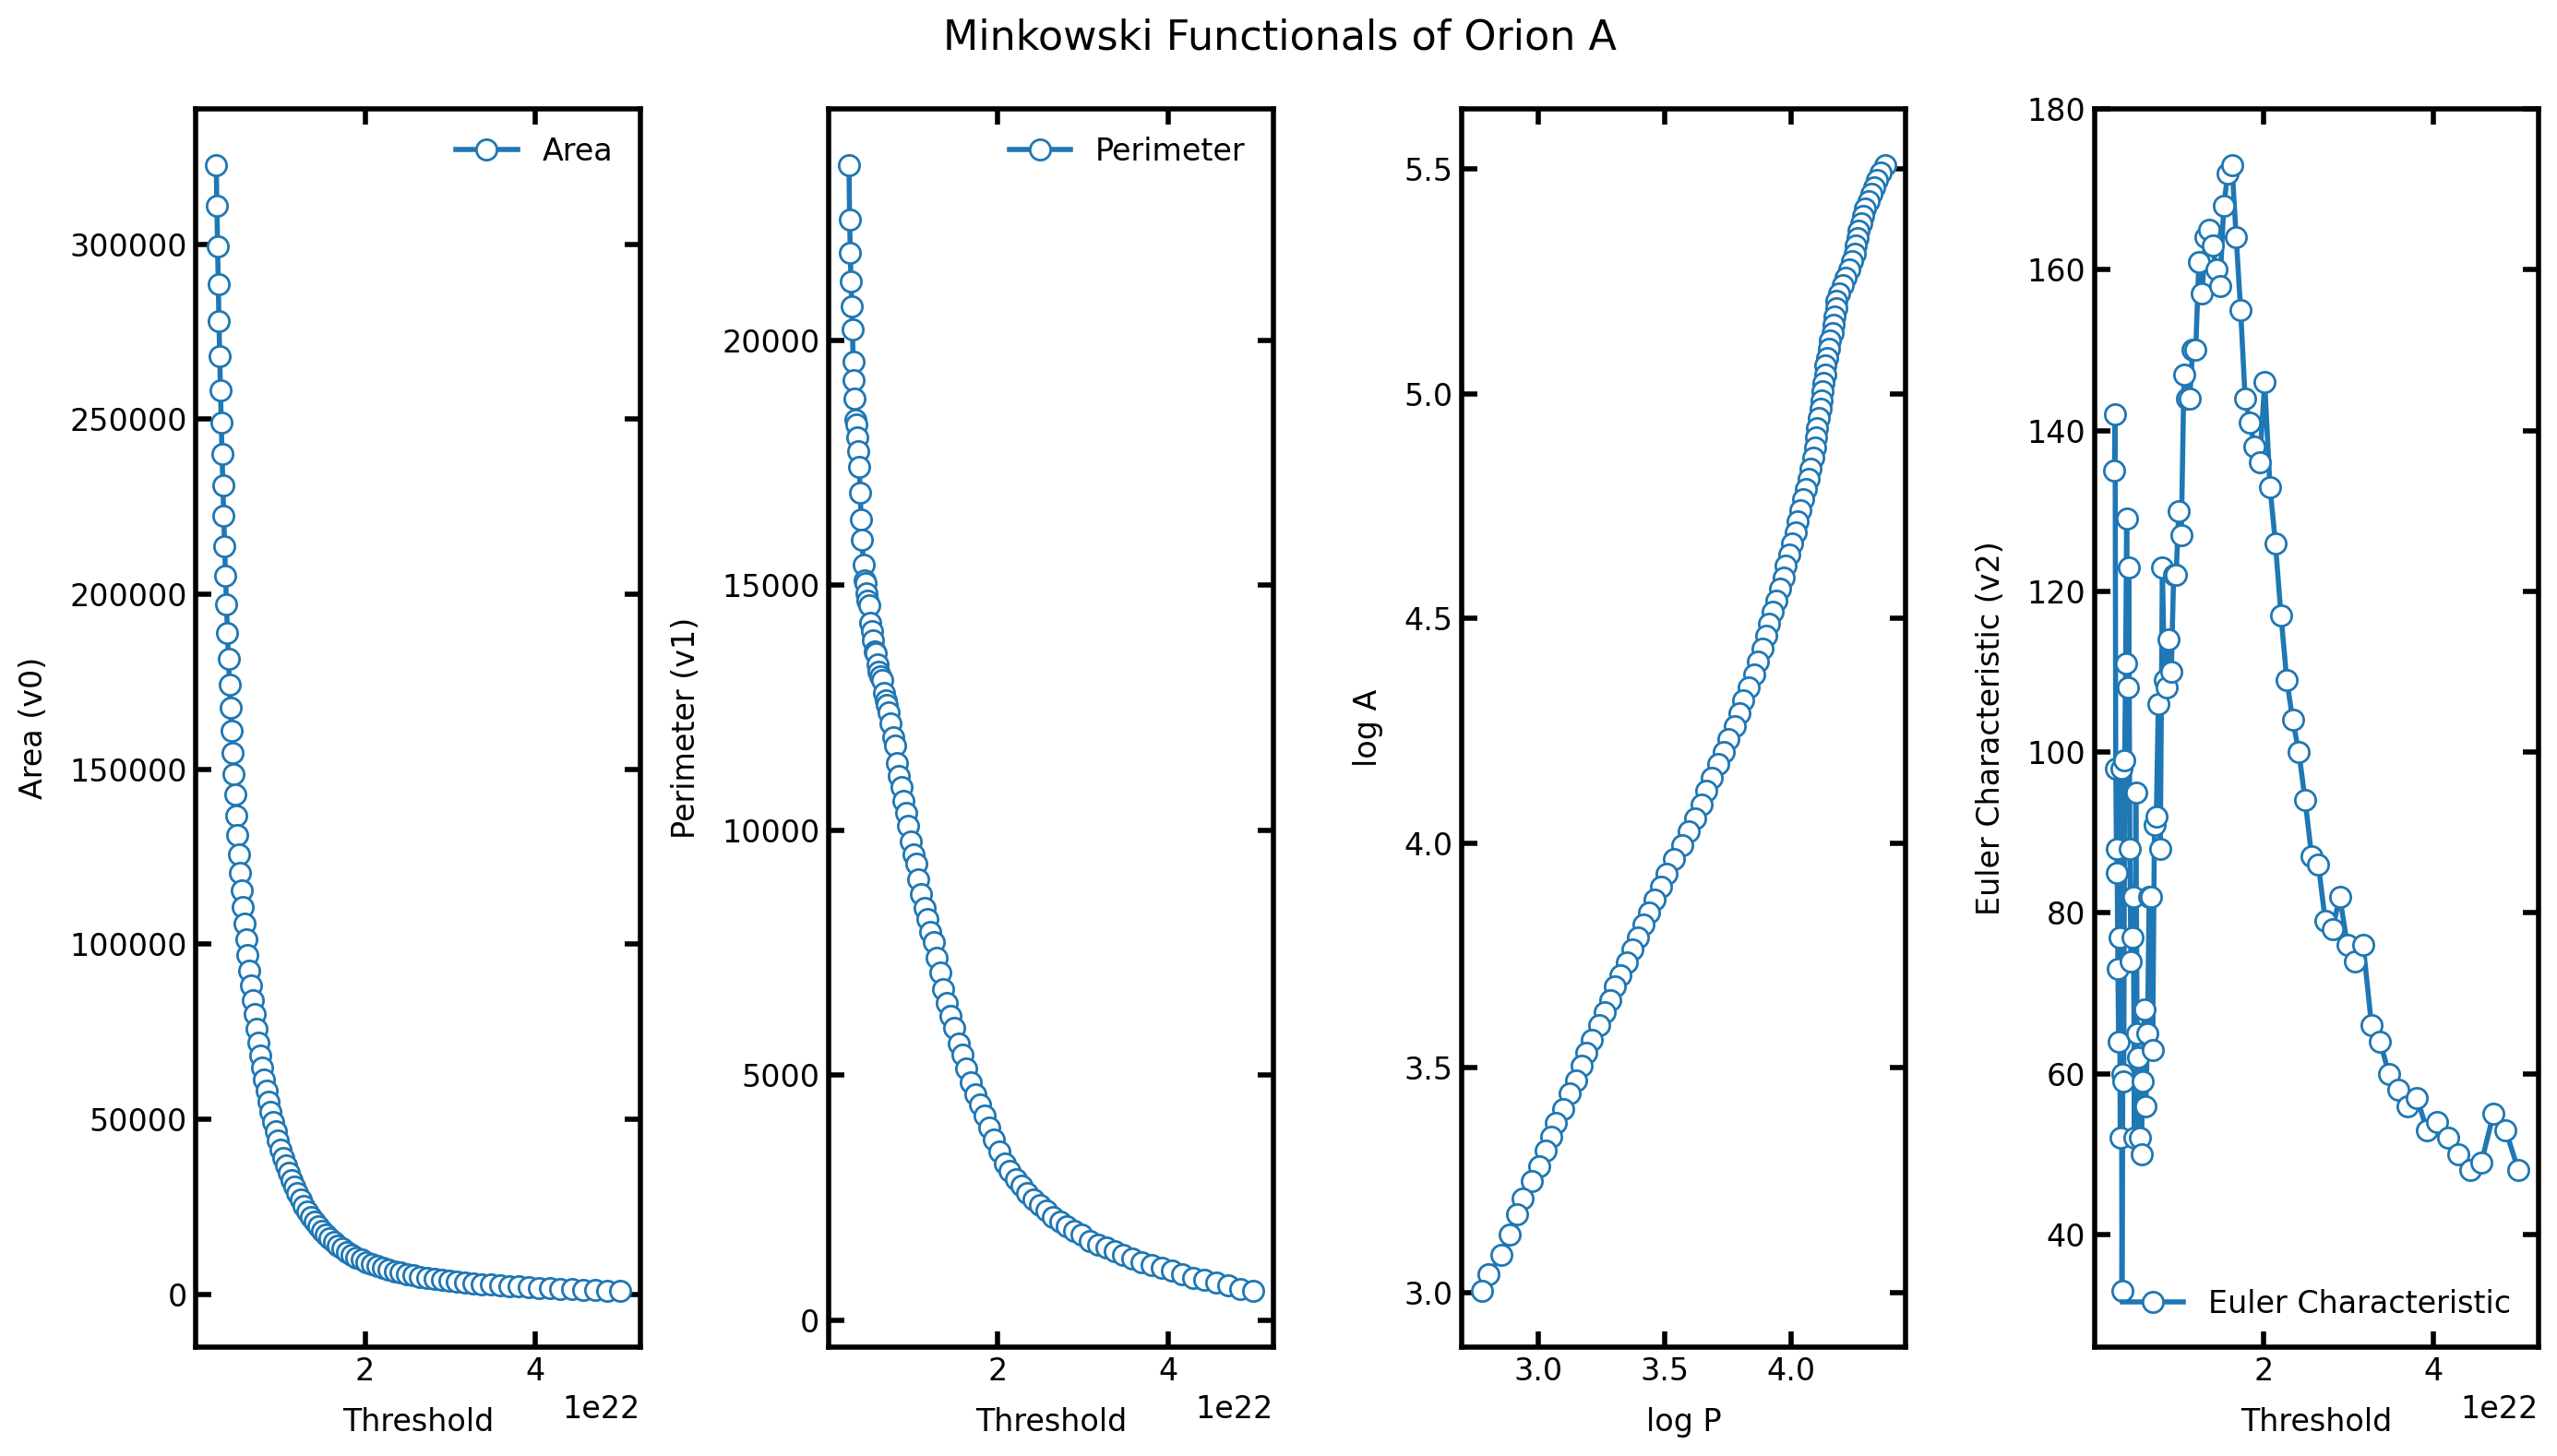

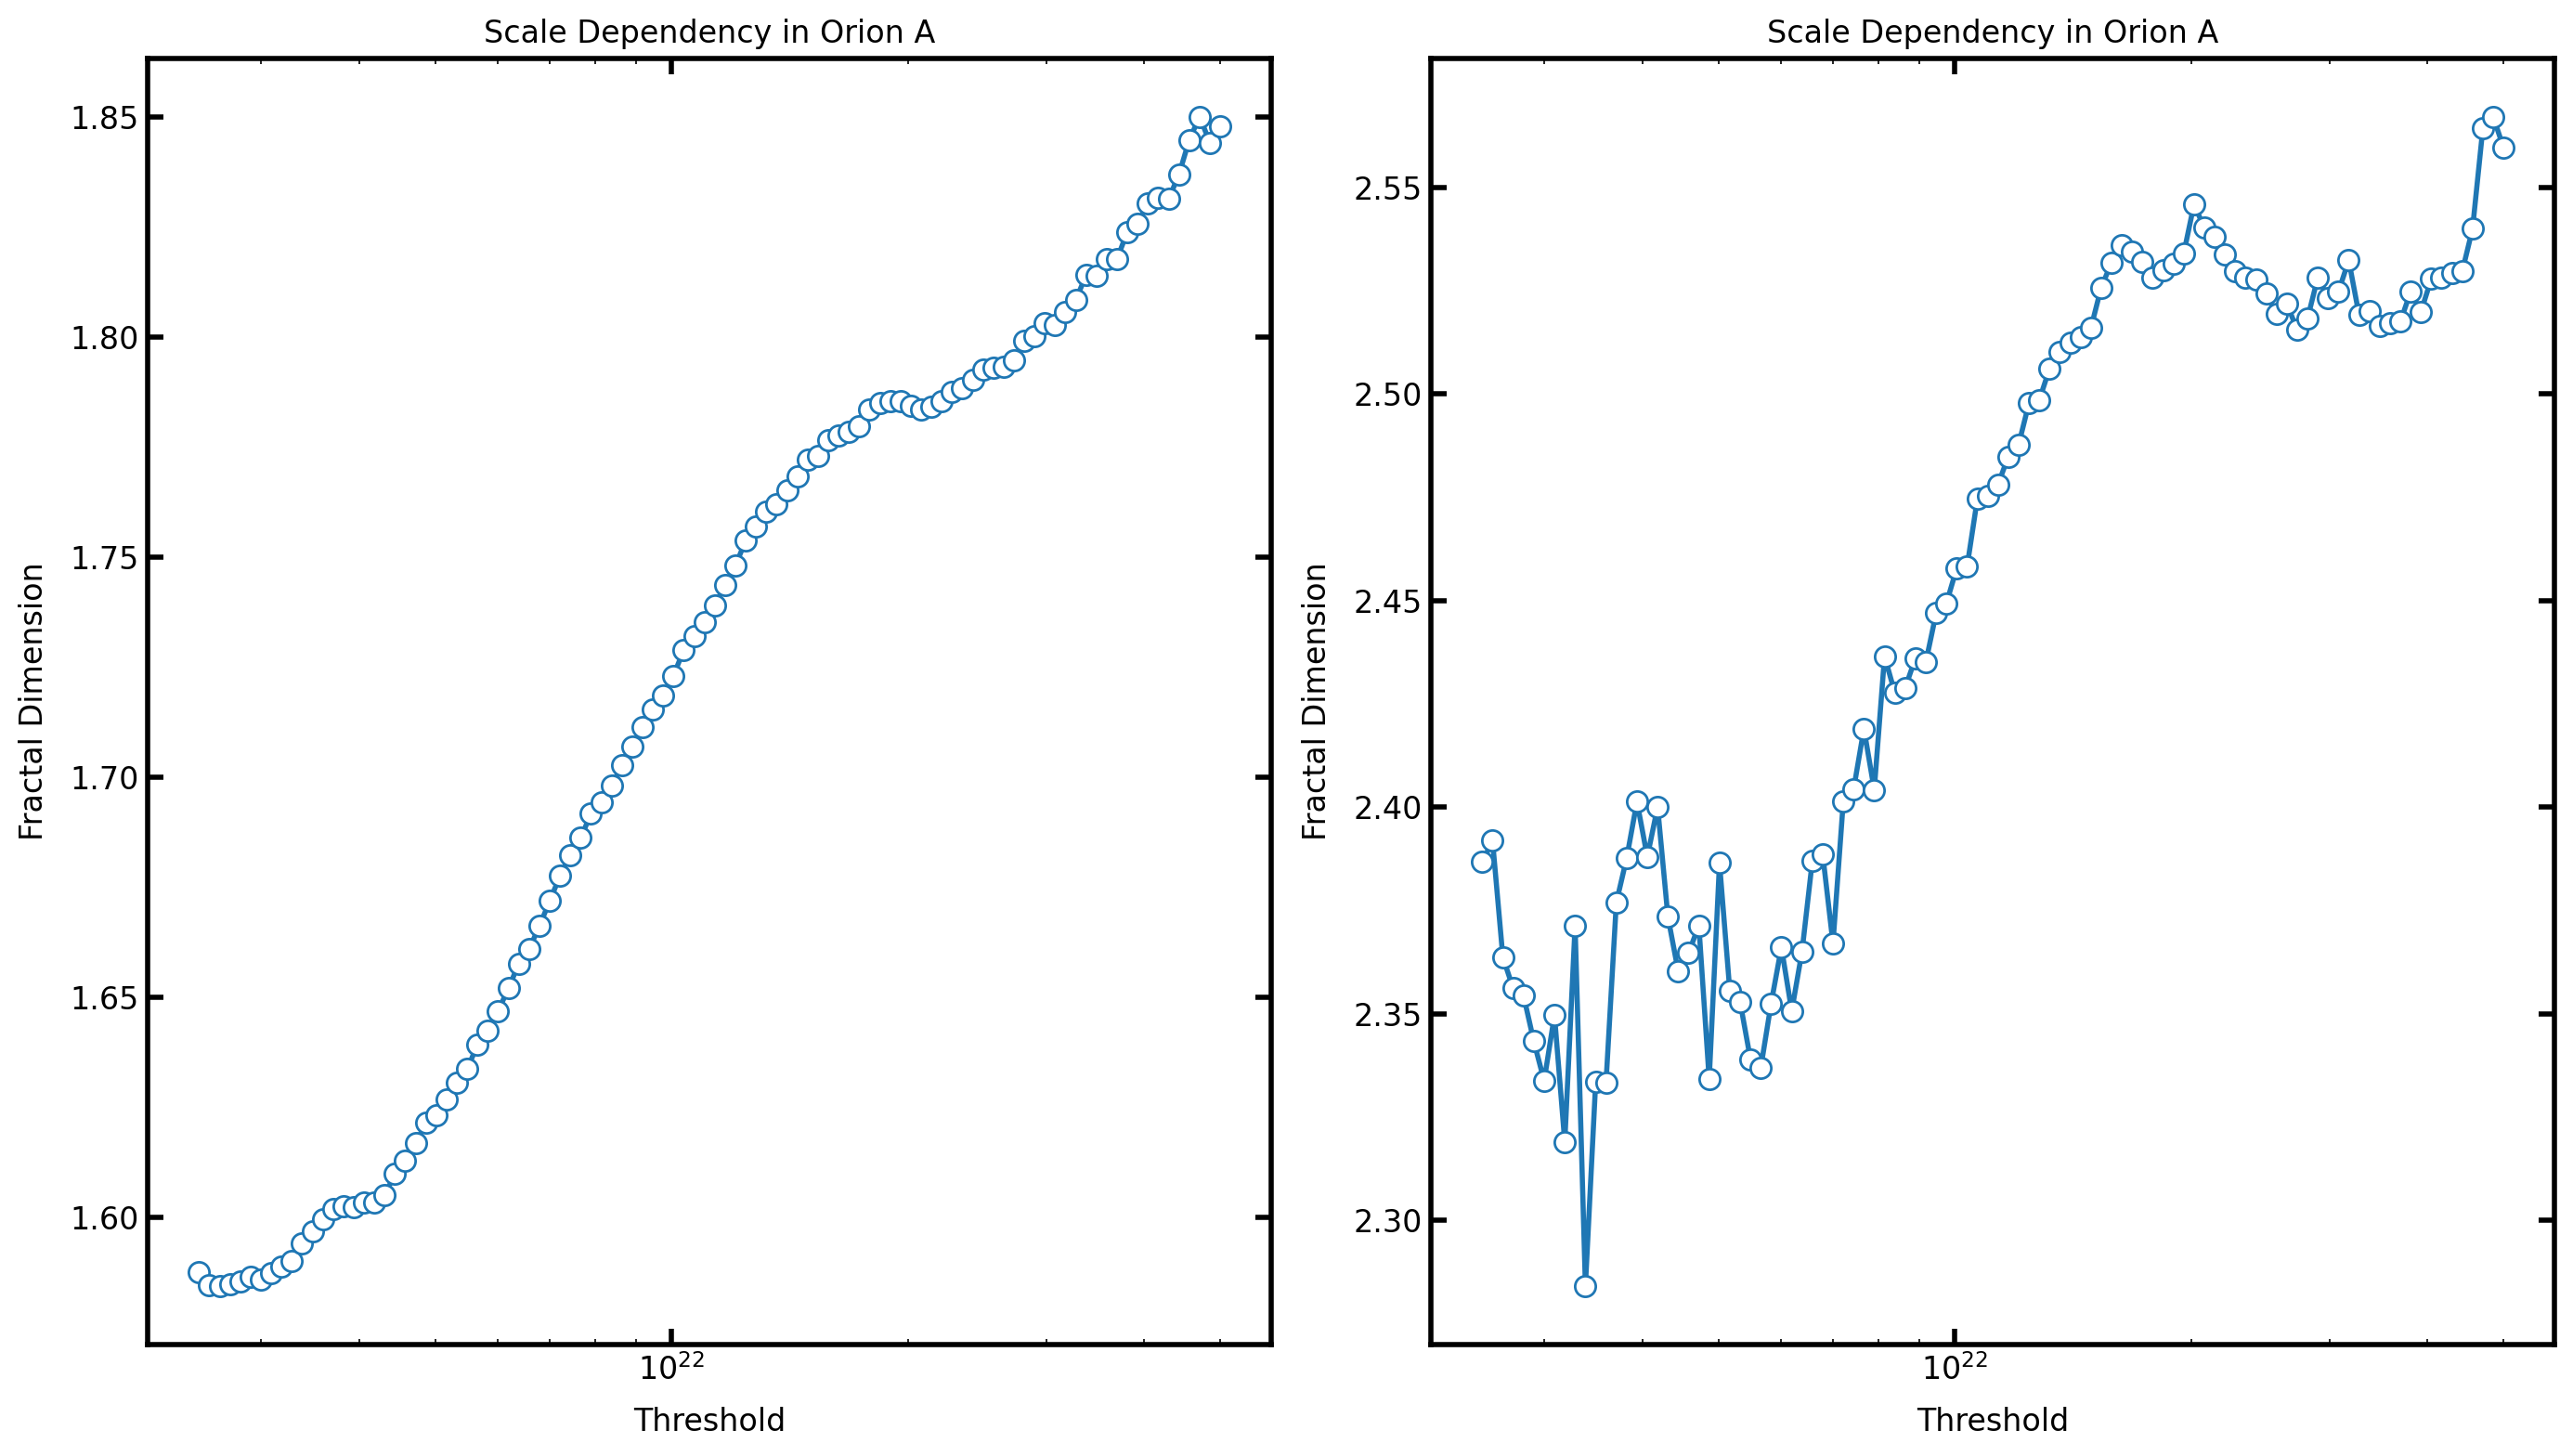

The average fractal dimension using the Perimeter-Area relation 1.731624666686625
The average fractal dimension using the v_2-Area relation 2.4477686578204456


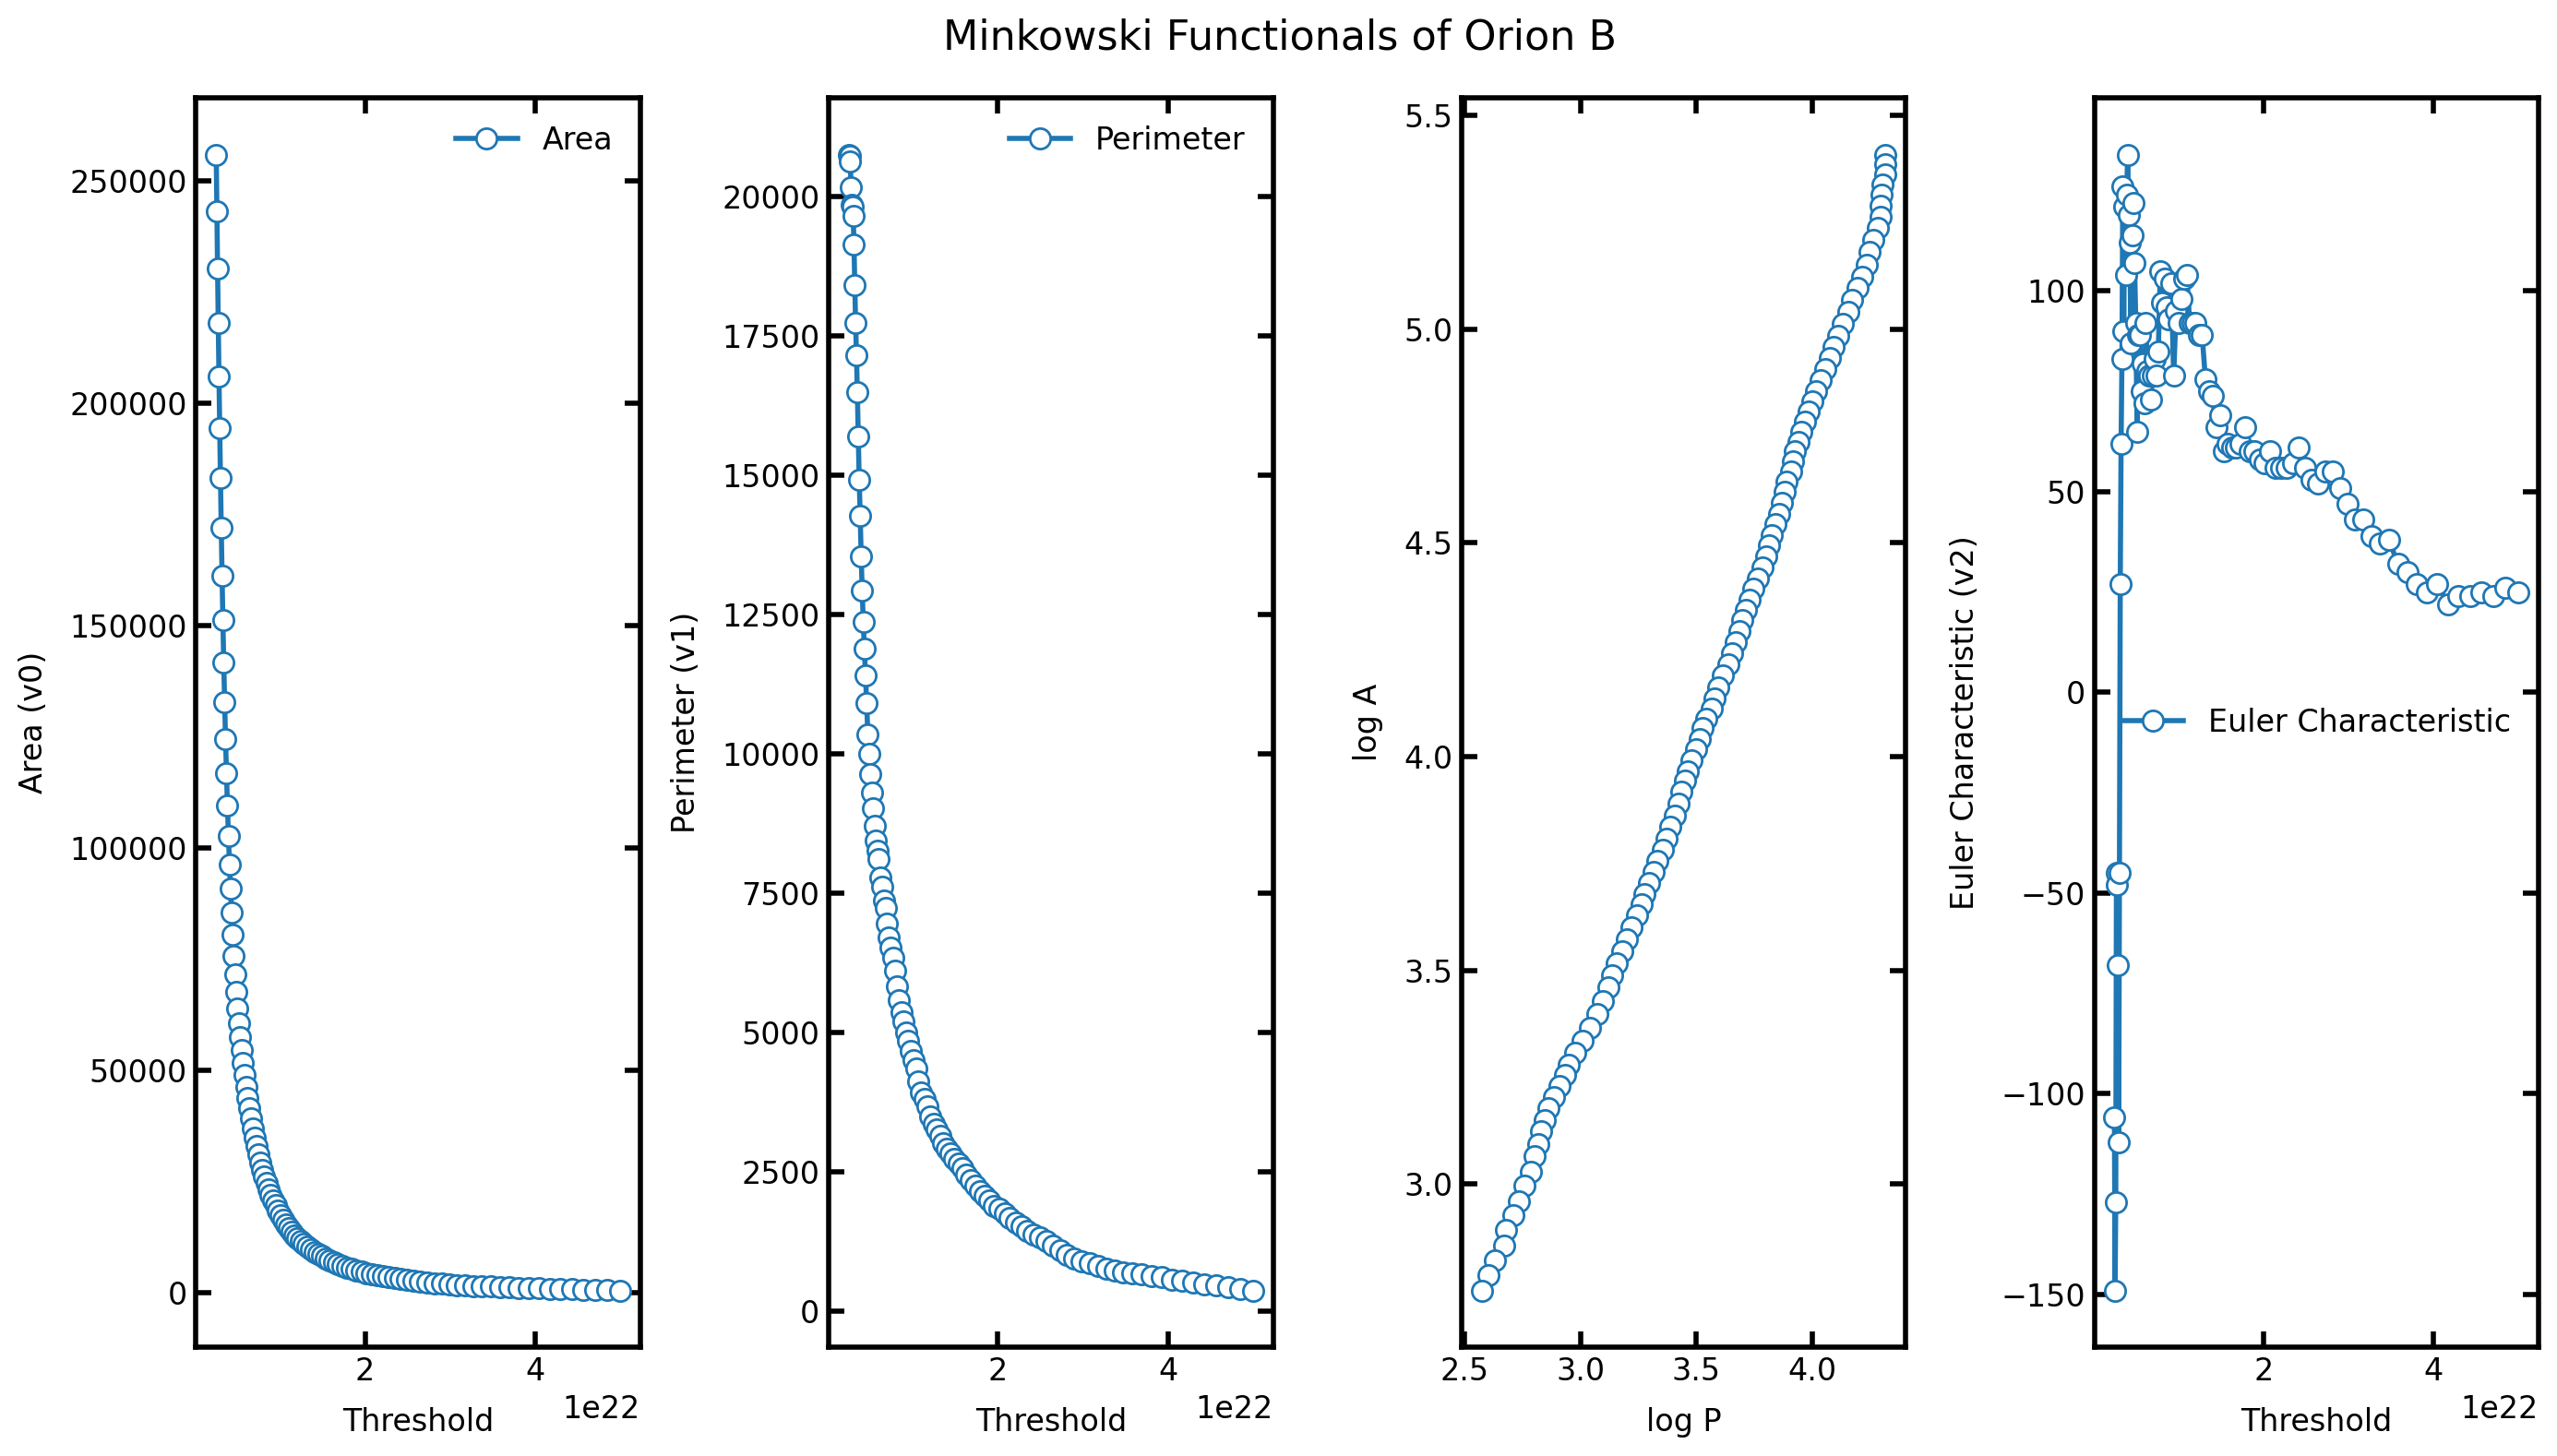

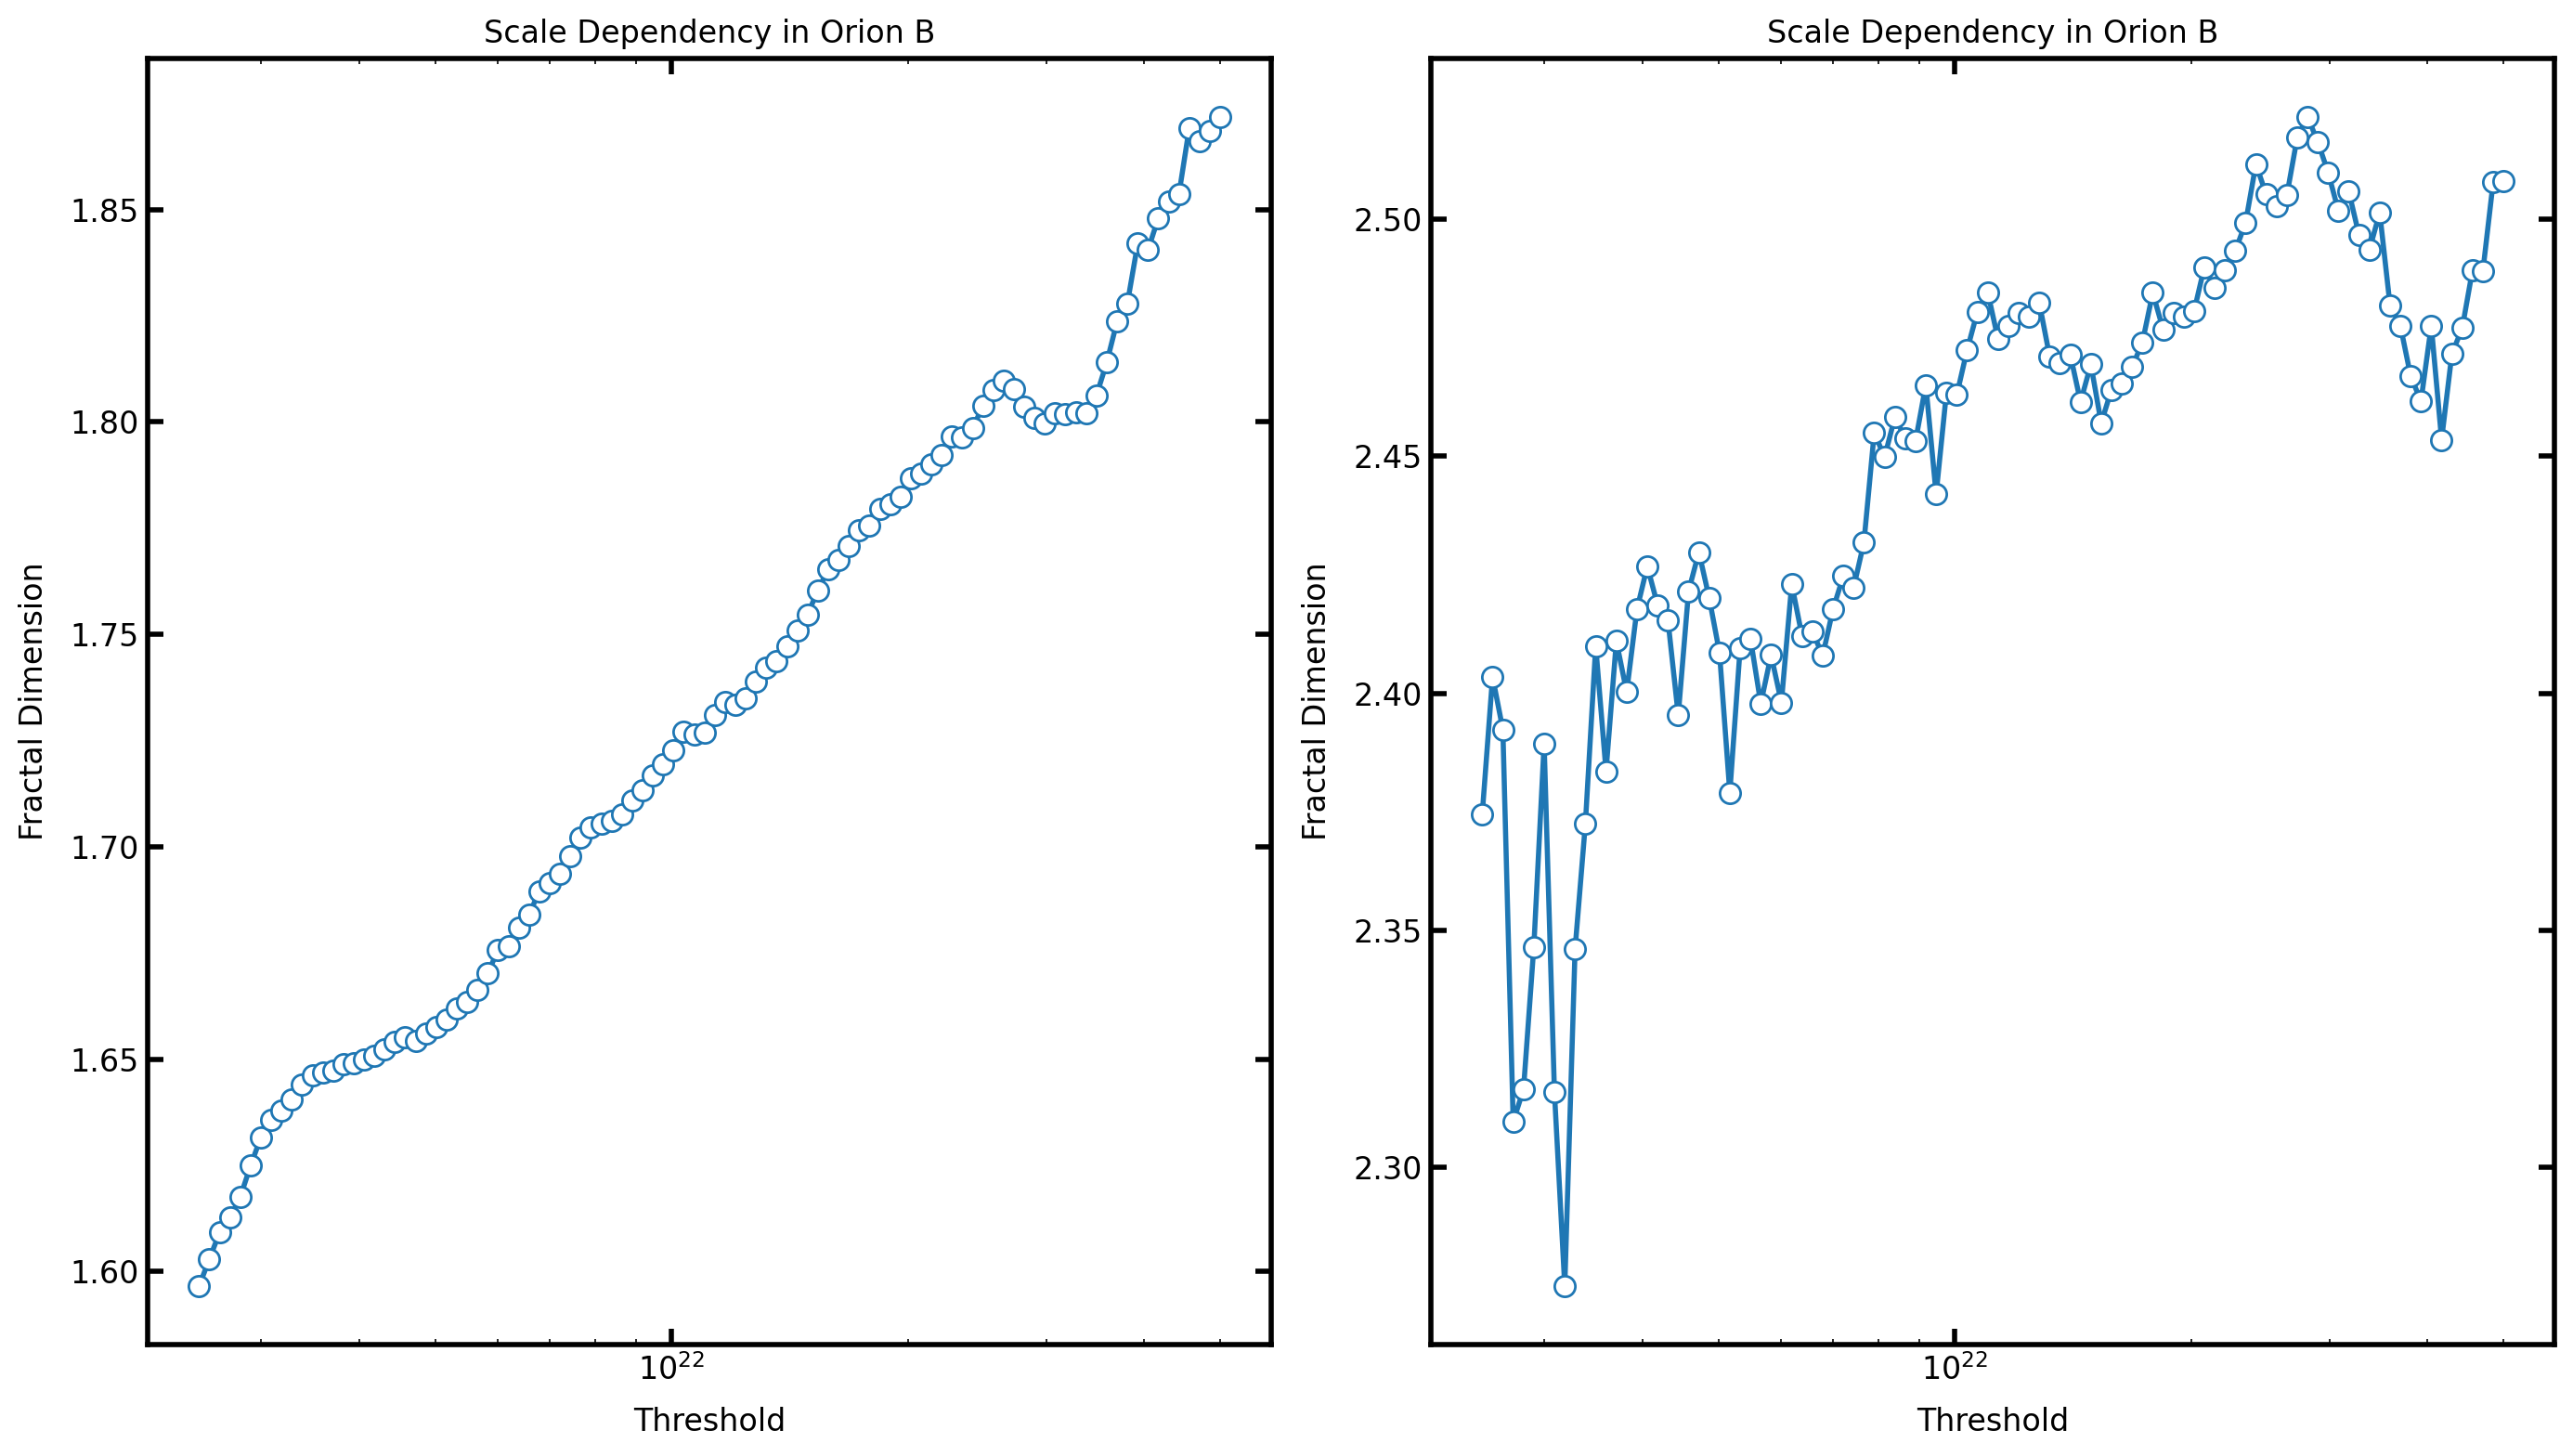

In [2]:
fractal_dimension_OA, thresholds_OA = minkowski_funct(N_H2_OA, region_name="Orion A", threshold_min = 2.5e21, threshold_max = 5e22)
fractal_dimension_OB, thresholds_OB = minkowski_funct(N_H2_OB, region_name="Orion B", threshold_min = 2.5e21, threshold_max = 5e22)

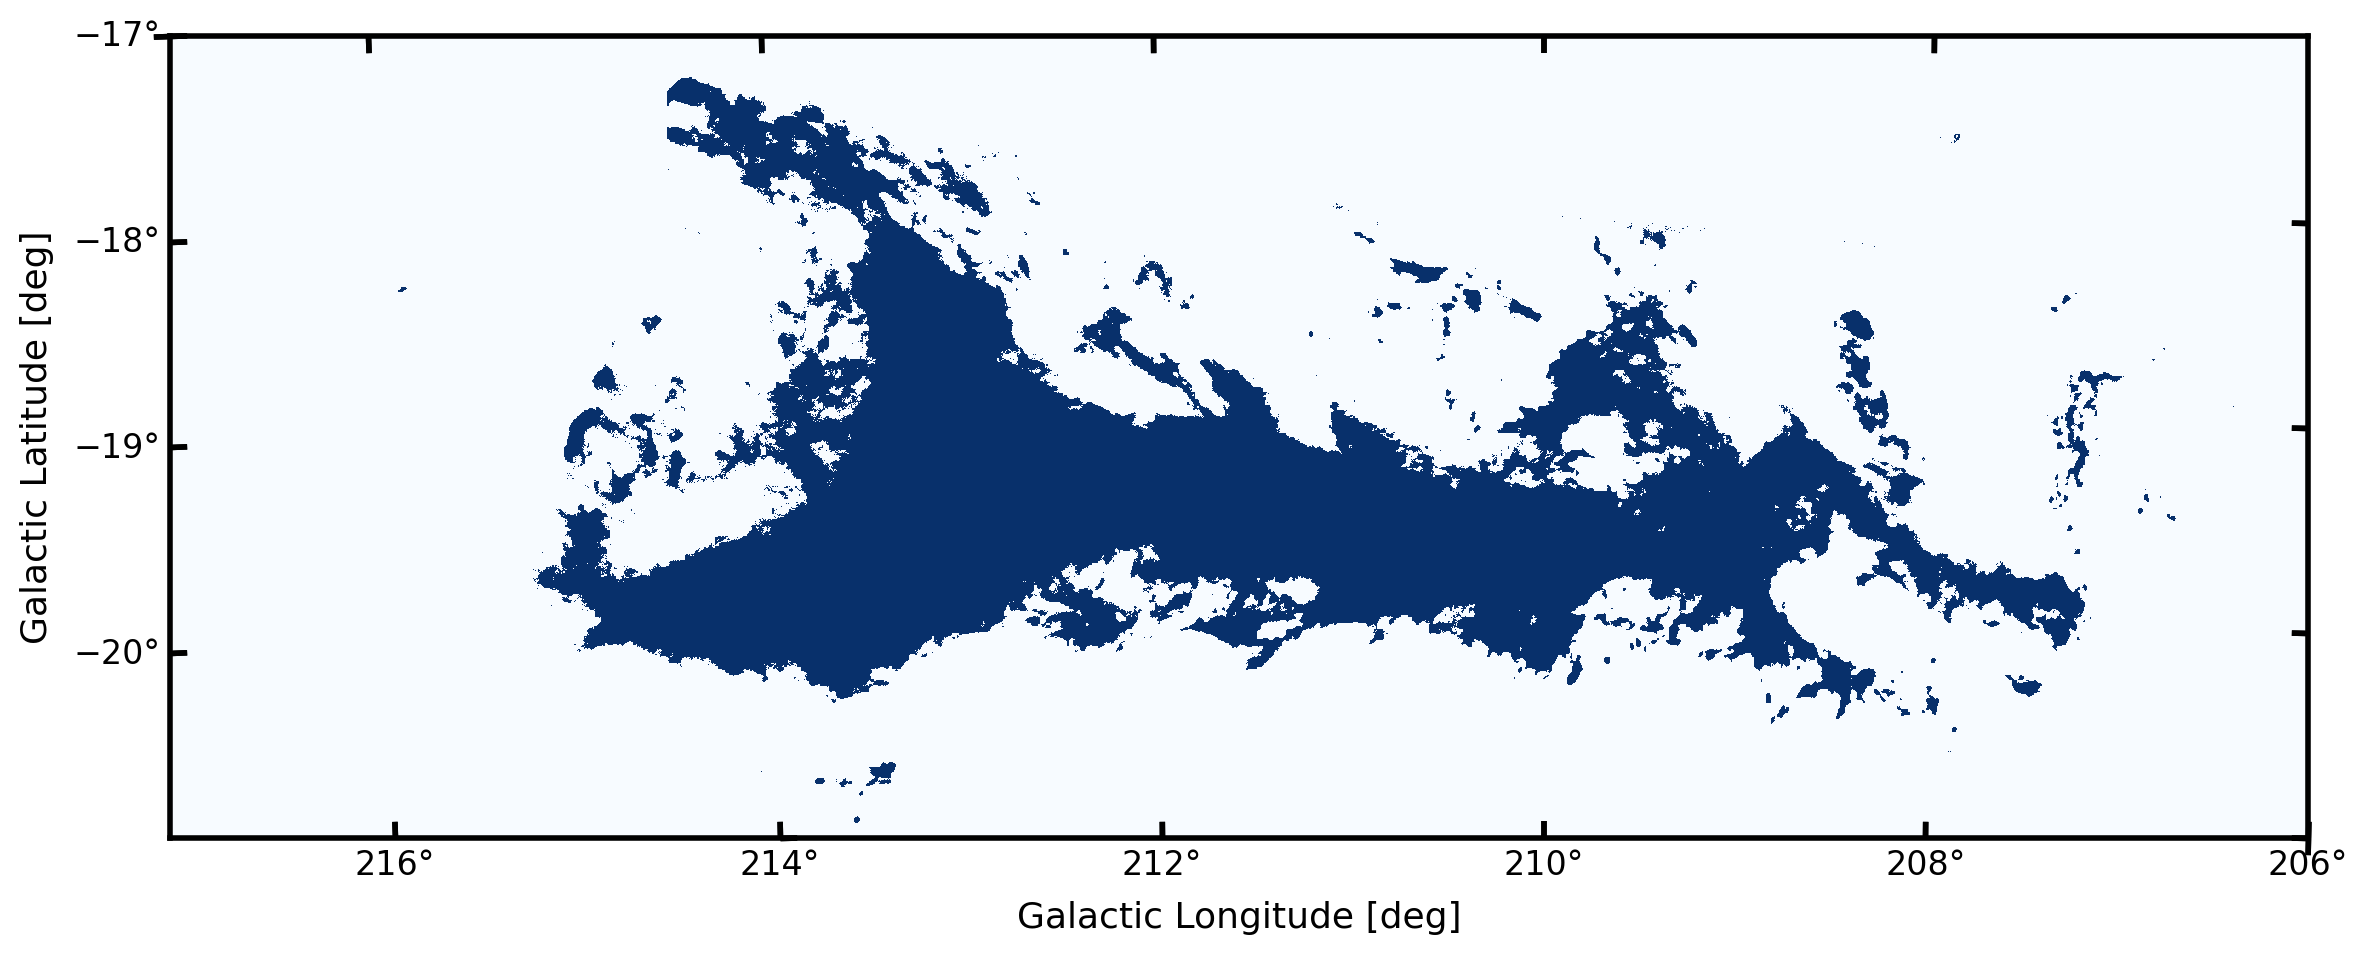

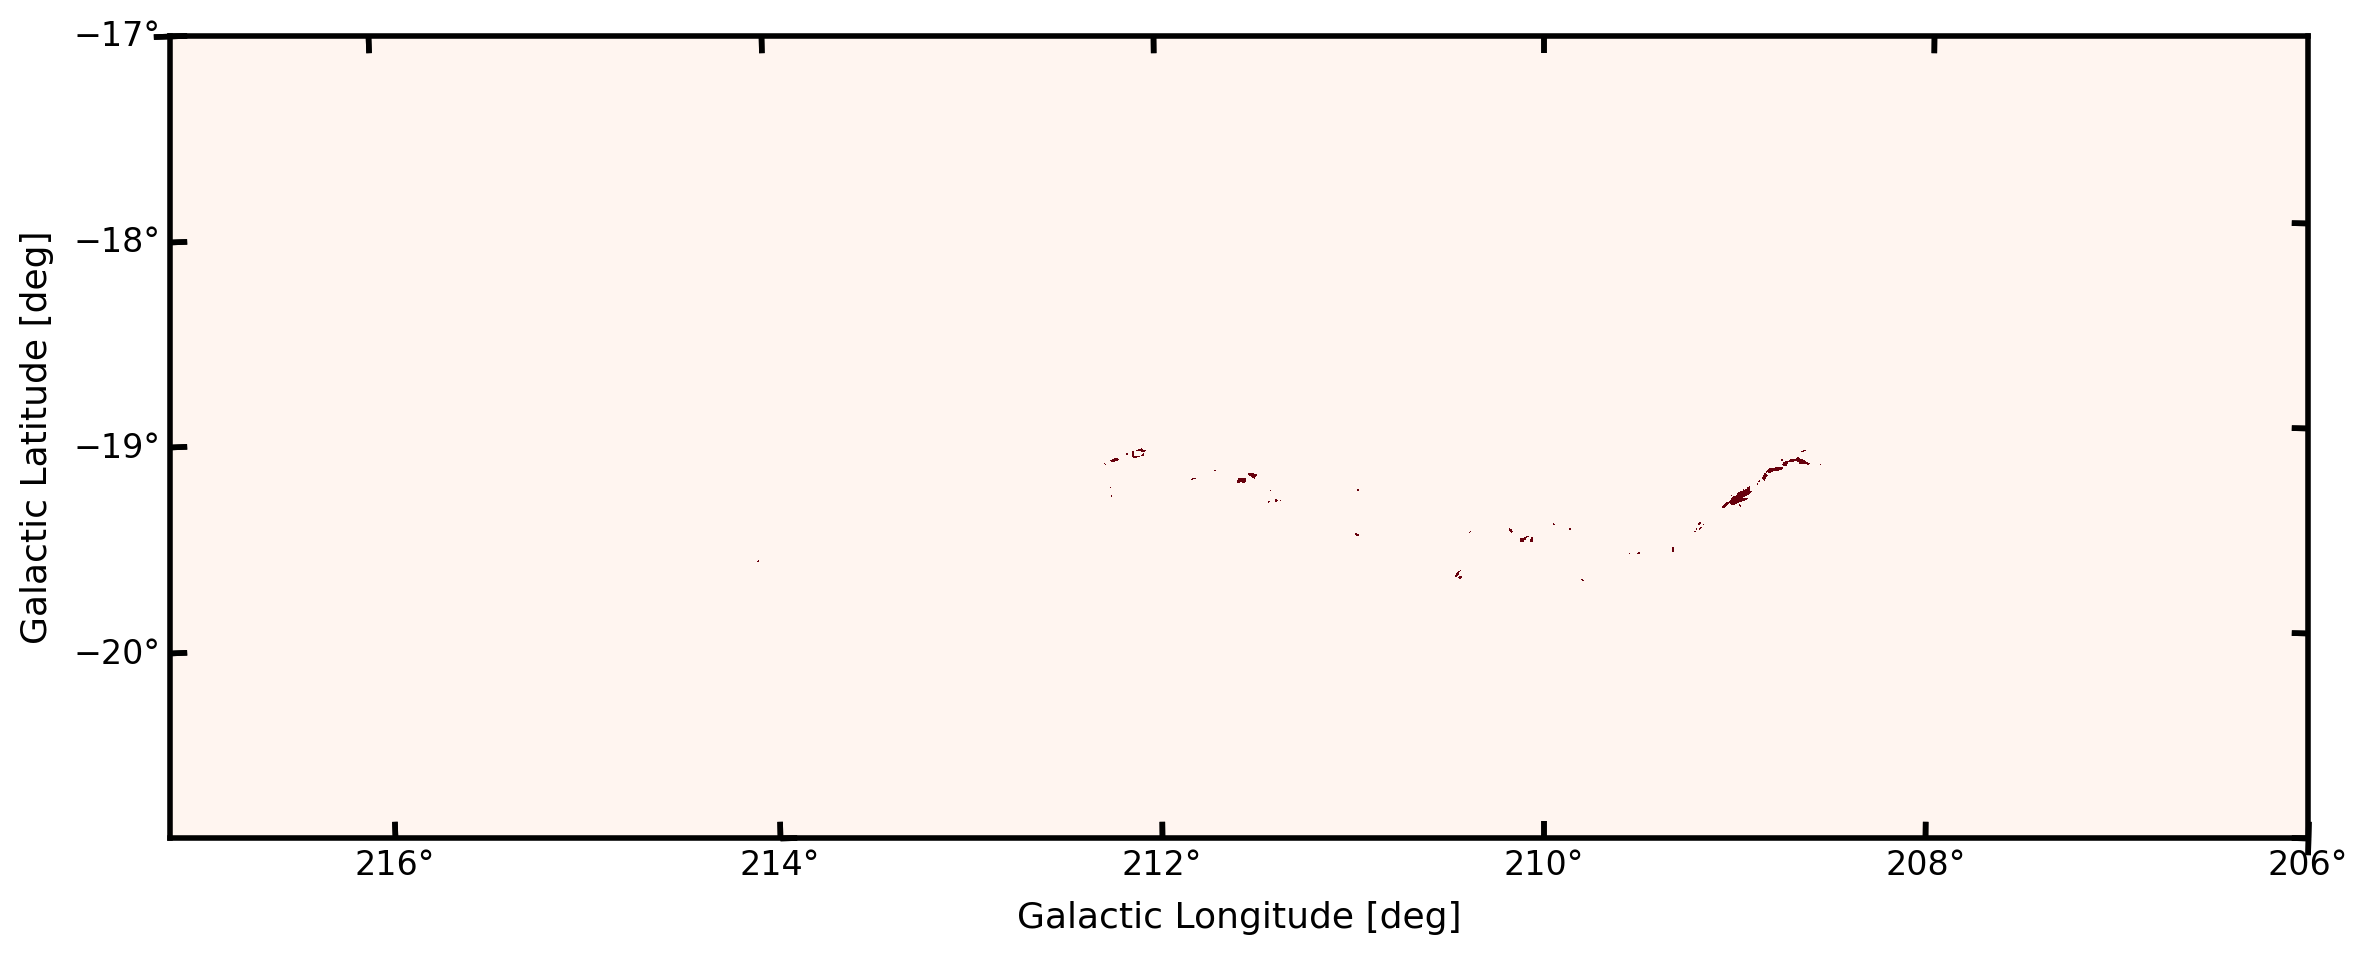

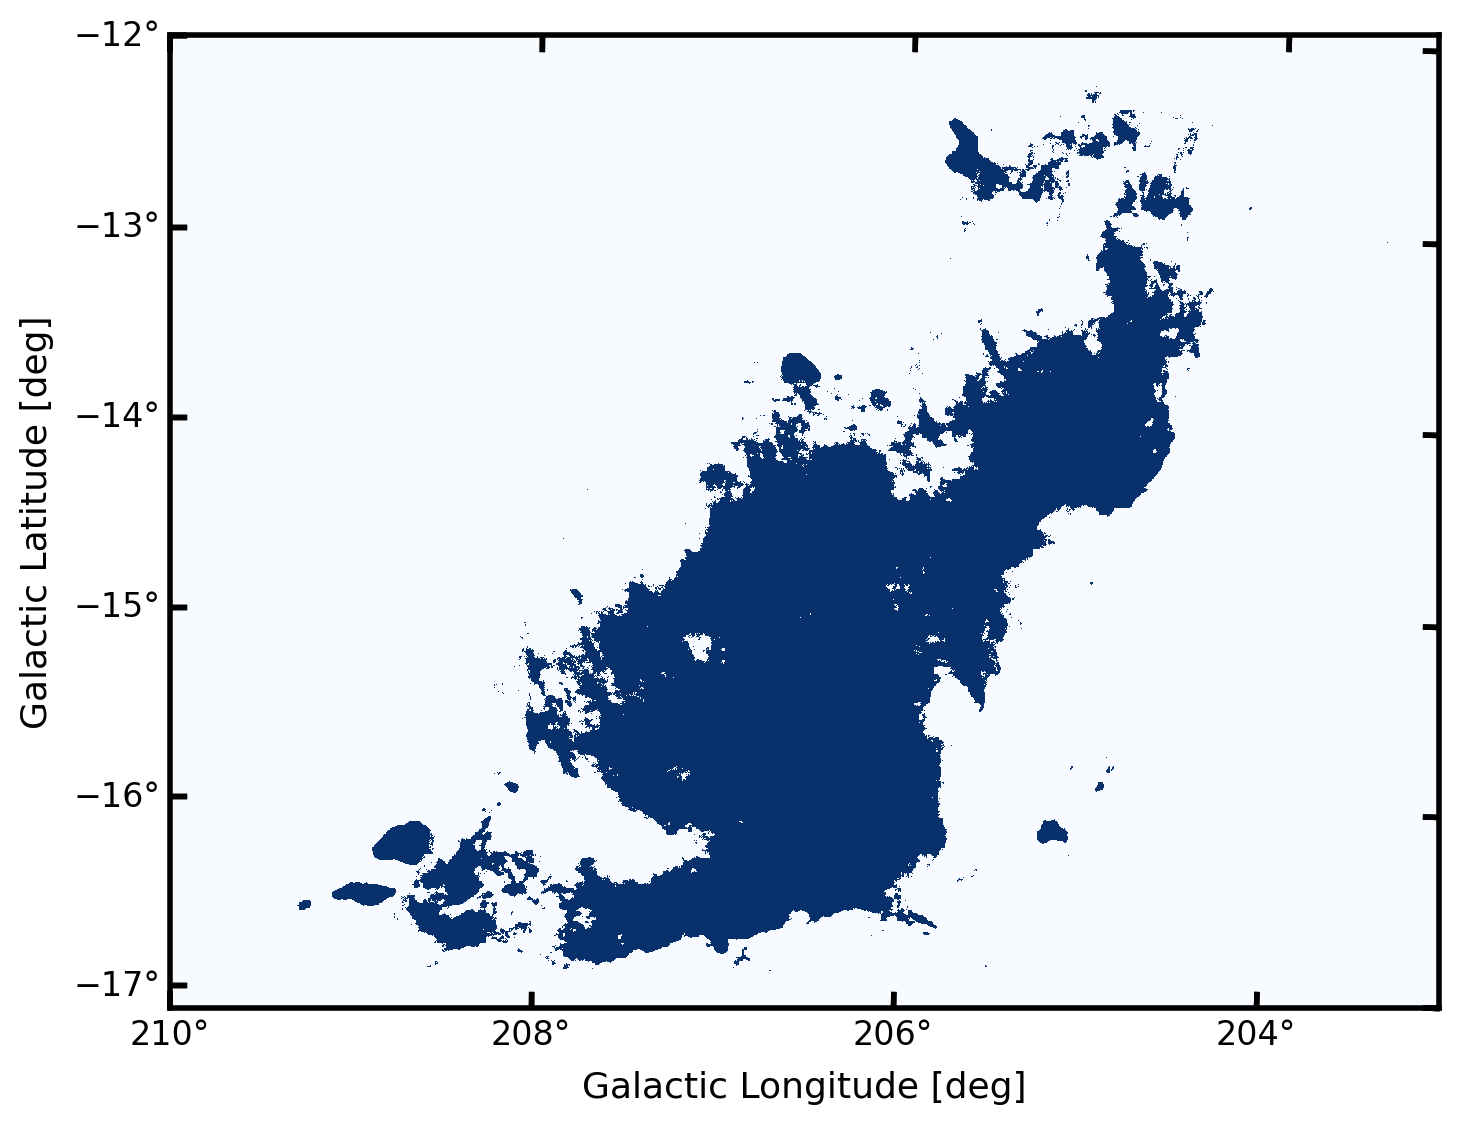

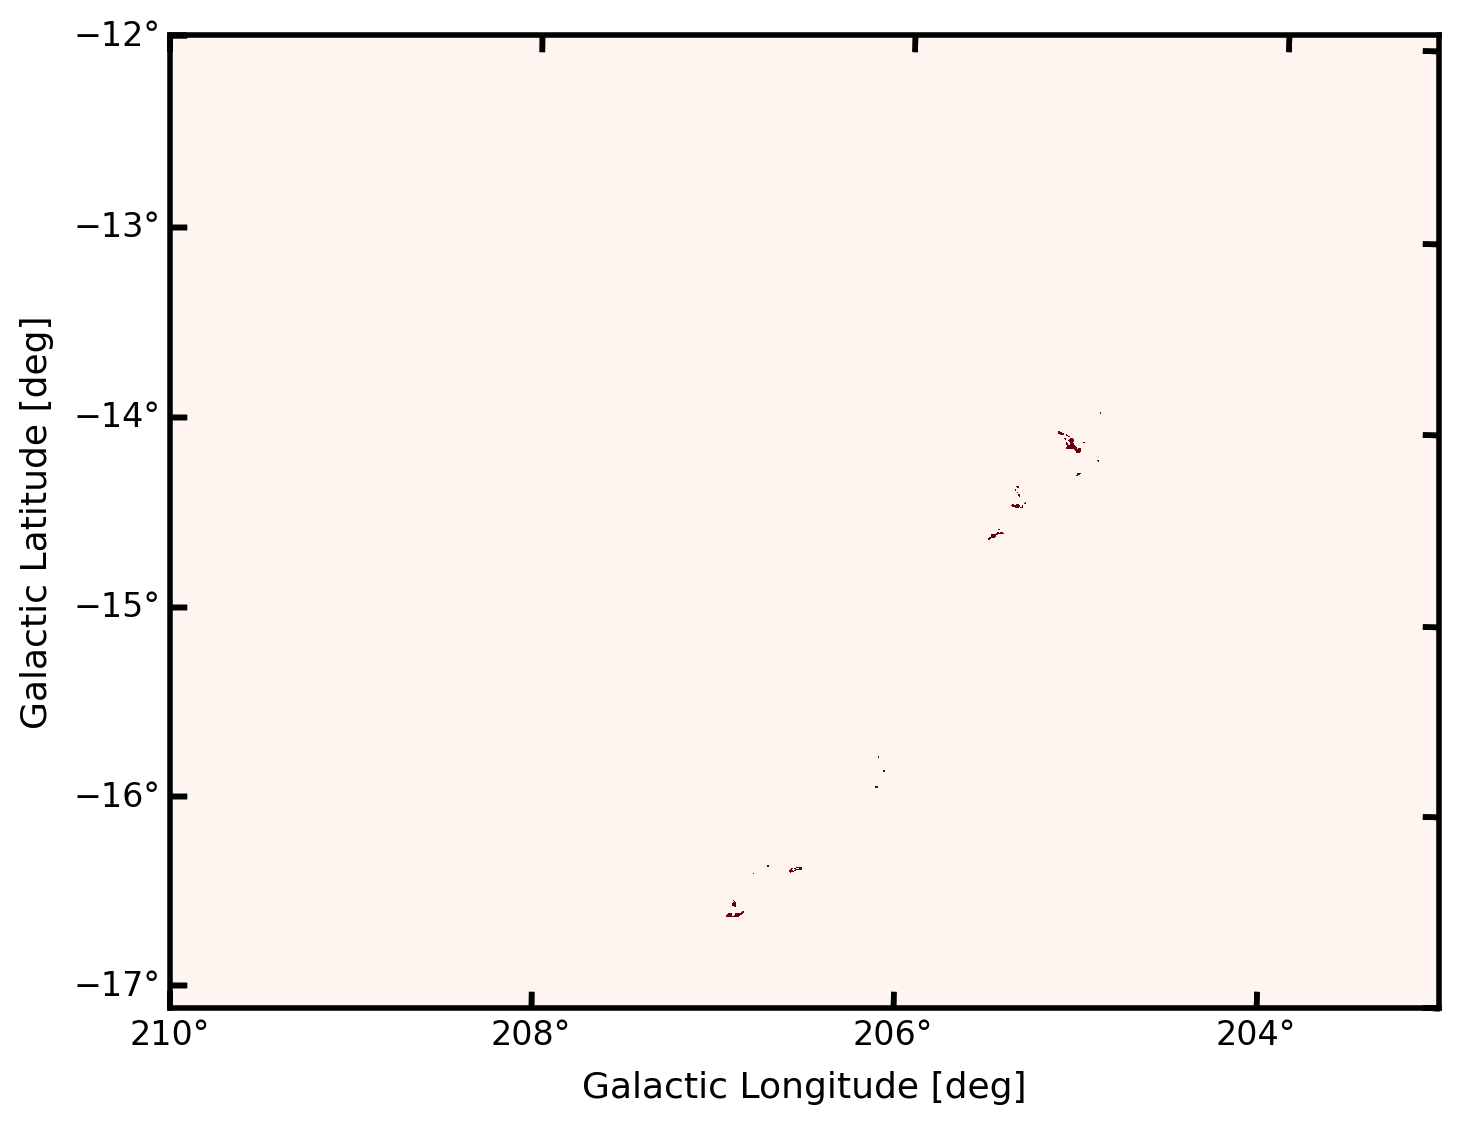

In [36]:
def plot_example_region(data, wcs, low_threshold = 2e21, high_threshold = 5e22):
    # Create binary masks
    low_mask = data >= low_threshold
    high_mask = data >= high_threshold

    l_min_A, l_max_A = 206, 217
    b_min_A, b_max_A = -21, -17

    min_coord_A = SkyCoord(l_min_A, b_min_A, frame='galactic', unit=u.deg)
    max_coord_A = SkyCoord(l_max_A, b_max_A, frame='galactic', unit=u.deg)

    min_pixel_A = wcs[:][:][0].world_to_pixel(min_coord_A)
    max_pixel_A = wcs[:][:][0].world_to_pixel(max_coord_A)

    l_min_B, l_max_B = 203, 210
    b_min_B, b_max_B = -17, -12

    min_coord_B = SkyCoord(l_min_B, b_min_B, frame='galactic', unit=u.deg)
    max_coord_B = SkyCoord(l_max_B, b_max_B, frame='galactic', unit=u.deg)

    min_pixel_B = wcs[:][:][0].world_to_pixel(min_coord_B)
    max_pixel_B = wcs[:][:][0].world_to_pixel(max_coord_B)

    # Visualize the low-threshold mask (A)
    plt.figure(figsize=(12, 10))
    ax_low = plt.subplot(111, projection=wcs[0])
    sp_low = ax_low.imshow(low_mask, origin='lower', interpolation=None, cmap='Blues')

    ax_low.set_xlabel("Galactic Longitude [deg]", fontsize=13)
    ax_low.set_ylabel("Galactic Latitude [deg]", fontsize=13)

    ax_low.set(xlim=[max_pixel_A[0], min_pixel_A[0]], ylim=[min_pixel_A[1], max_pixel_A[1]])
    plt.show()

    # Visualize the high-threshold mask (A)
    plt.figure(figsize=(12, 10))
    ax_high = plt.subplot(111, projection=wcs[0])
    sp_high = ax_high.imshow(high_mask, origin='lower', cmap='Reds', interpolation=None)

    ax_high.set_xlabel("Galactic Longitude [deg]", fontsize=13)
    ax_high.set_ylabel("Galactic Latitude [deg]", fontsize=13)

    ax_high.set(xlim=[max_pixel_A[0], min_pixel_A[0]], ylim=[min_pixel_A[1], max_pixel_A[1]])
    plt.show()

    # Visualize the low-threshold mask (B)
    plt.figure(figsize=(40, 40))
    ax_low = plt.subplot(111, projection=wcs[0])
    sp_low = ax_low.imshow(low_mask, origin='lower', interpolation=None, cmap='Blues')

    ax_low.set_xlabel("Galactic Longitude [deg]", fontsize=13)
    ax_low.set_ylabel("Galactic Latitude [deg]", fontsize=13)

    ax_low.set(xlim=[max_pixel_B[0], min_pixel_B[0]], ylim=[min_pixel_B[1], max_pixel_B[1]])
    plt.show()

    # Visualize the high-threshold mask (B)
    plt.figure(figsize=(40, 40))
    ax_high = plt.subplot(111, projection=wcs[0])
    sp_high = ax_high.imshow(high_mask, origin='lower', cmap='Reds', interpolation=None)

    ax_high.set_xlabel("Galactic Longitude [deg]", fontsize=13)
    ax_high.set_ylabel("Galactic Latitude [deg]", fontsize=13)

    ax_high.set(xlim=[max_pixel_B[0], min_pixel_B[0]], ylim=[min_pixel_B[1], max_pixel_B[1]])
    plt.show()

plot_example_region(N_H2, wcs)

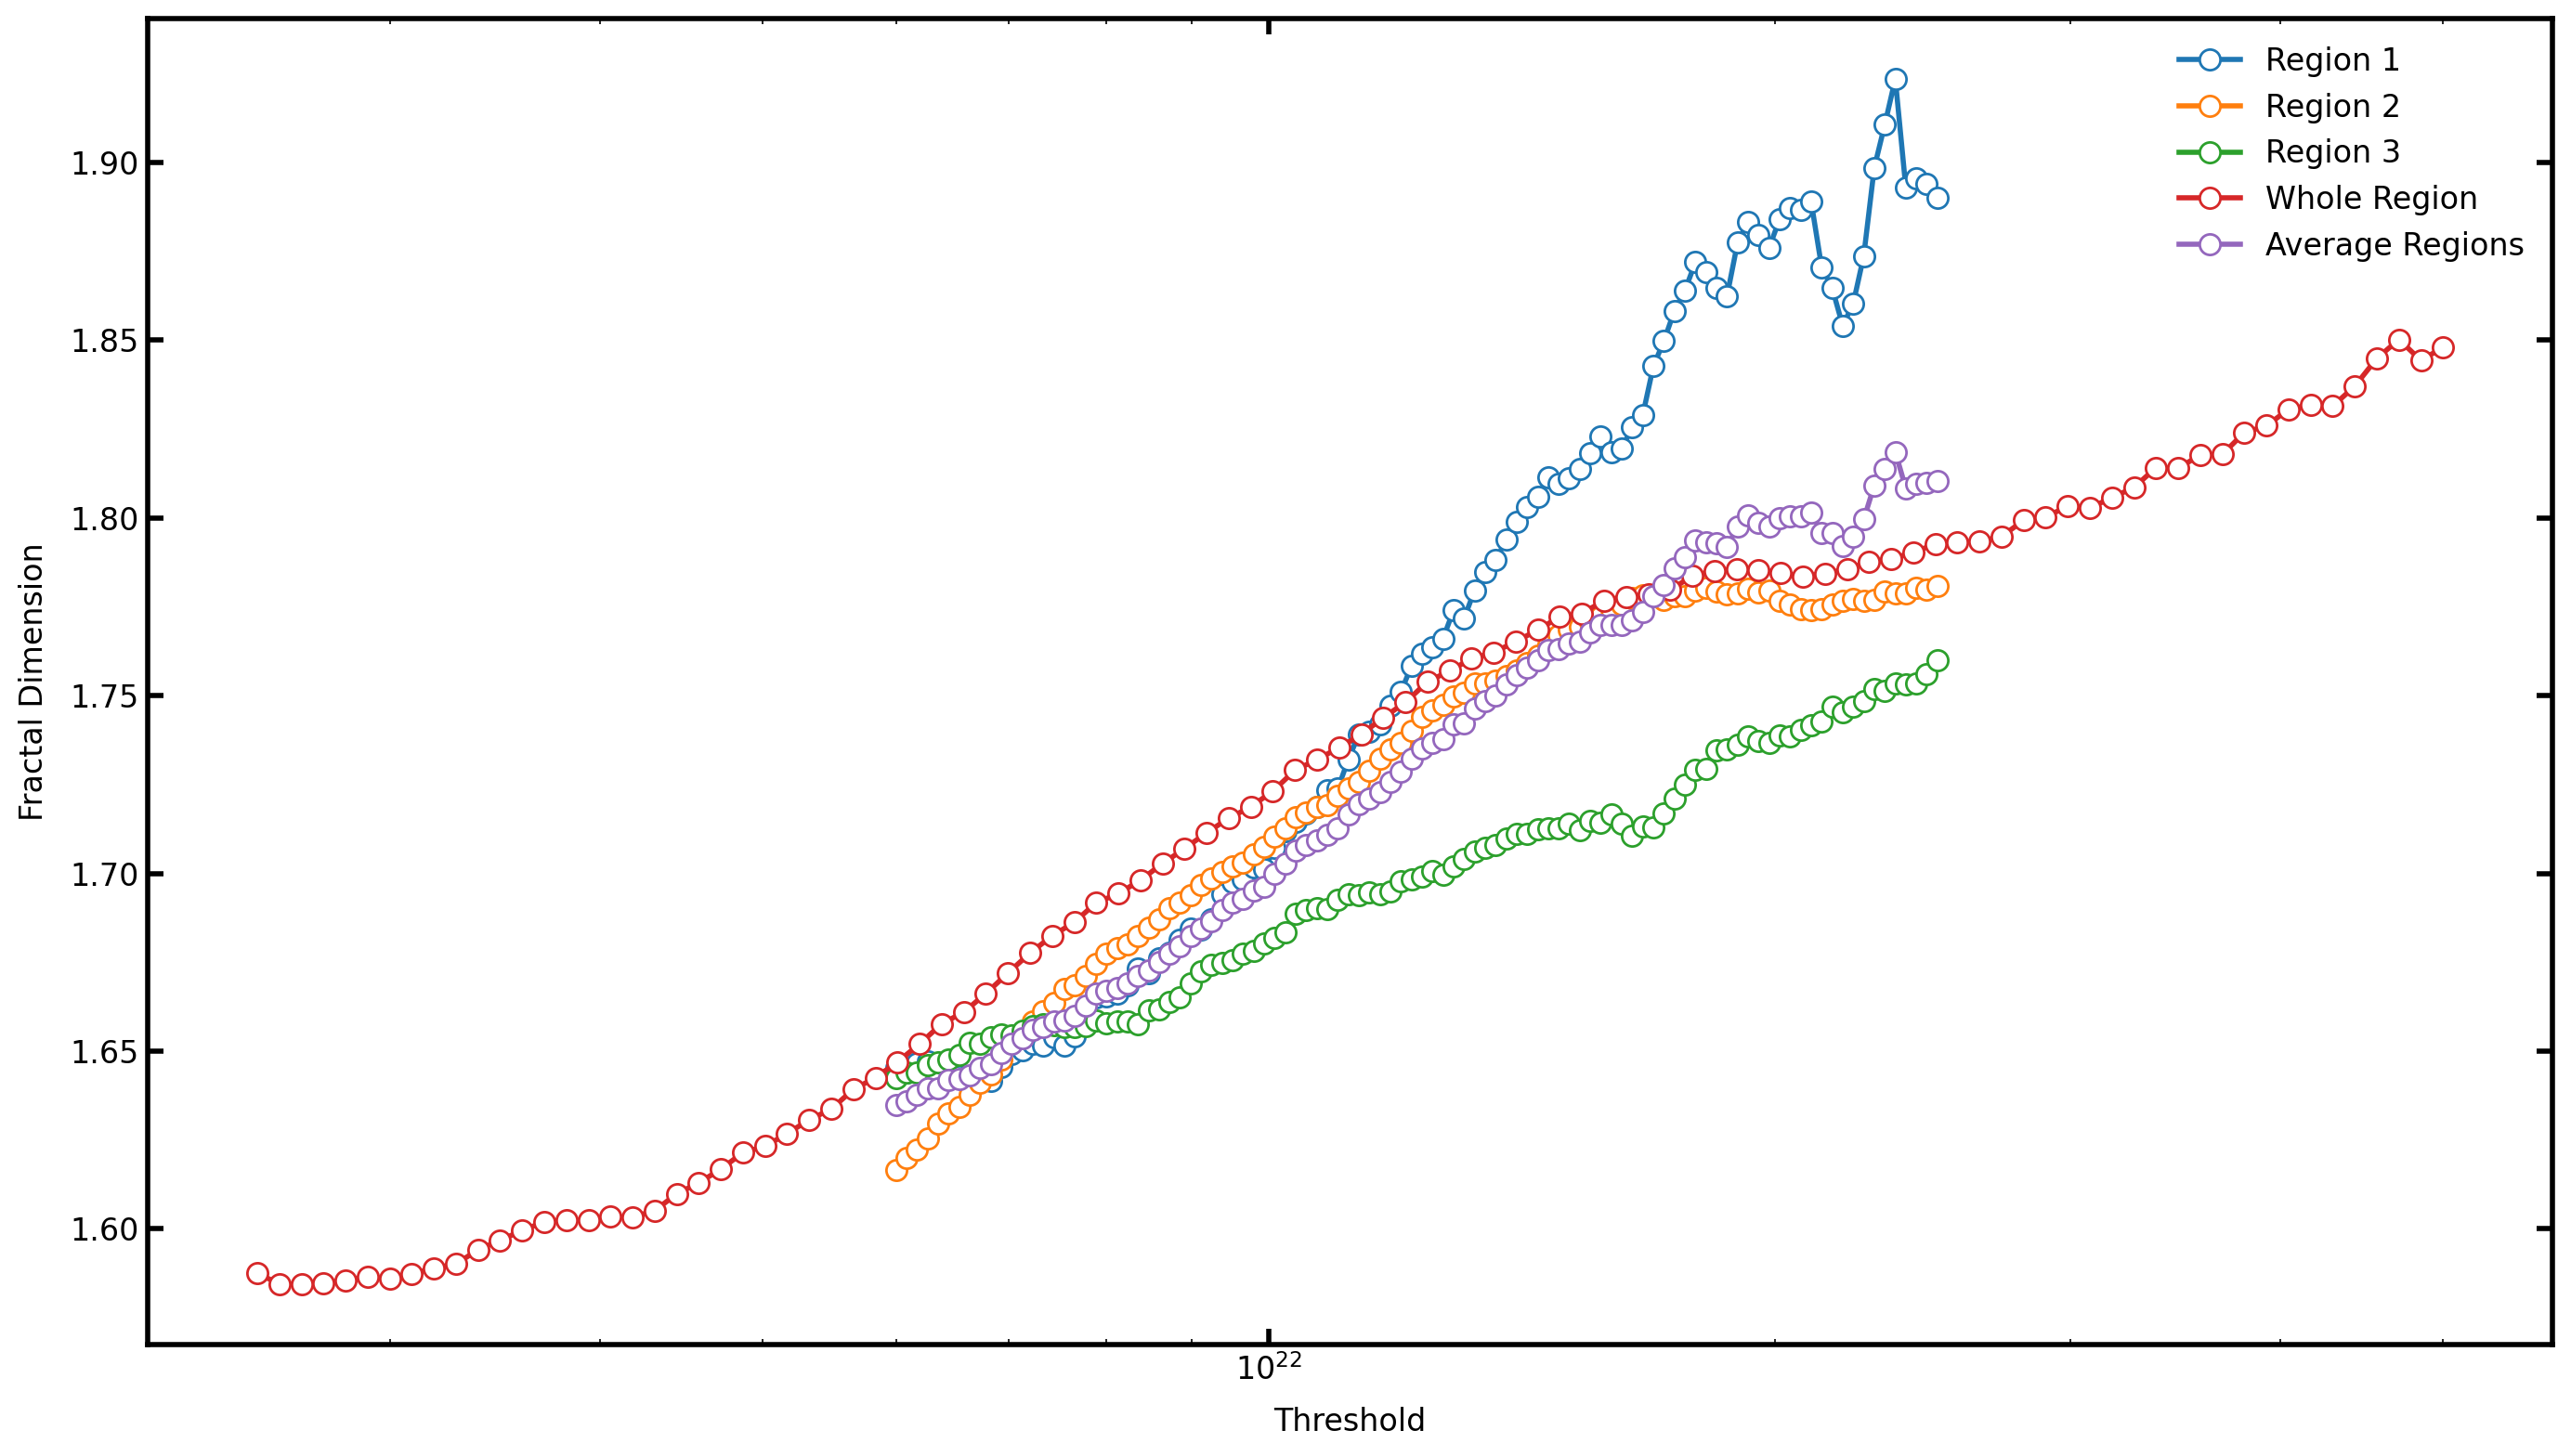

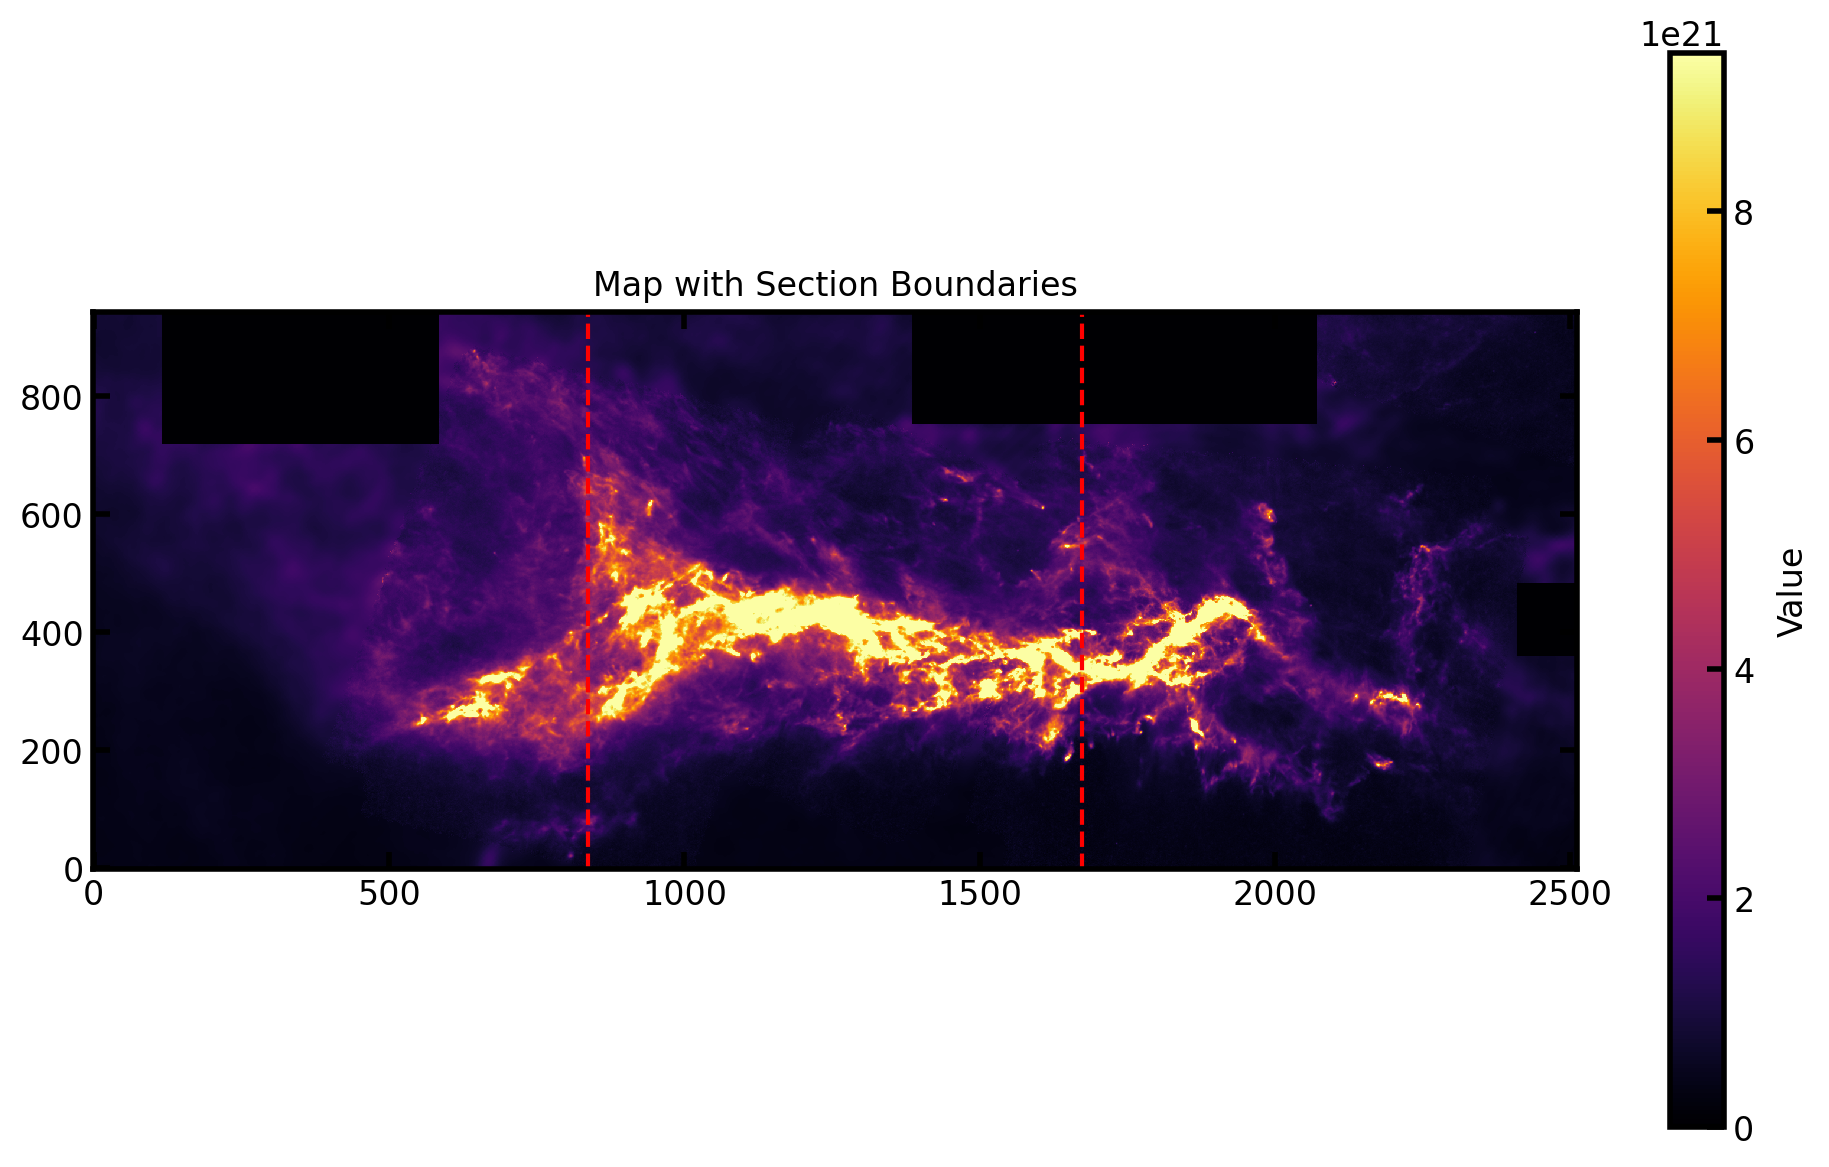

<Figure size 640x480 with 0 Axes>

In [ ]:
# like above, just divided into N sections
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

def show_sections(data, n_regions=3):
    height, width = data.shape
    # Determine step size for slicing along the y-axis
    w_step = width // n_regions

    # Define the color limits based on percentiles
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

    min_value = np.percentile(data, 2)  # 2nd percentile
    max_value = np.percentile(data, 98)  # 98th percentile

    # Plot the entire data map
    plt.figure(figsize=(10, 6))
    plt.imshow(data, vmin=min_value, vmax=max_value, interpolation=None, origin='lower', cmap='inferno')

    # Draw vertical lines to indicate section boundaries
    for i in range(1, n_regions):
        plt.axvline(x=i * w_step, color="red", linestyle="--", linewidth=1.5)

    plt.title("Map with Section Boundaries")
    plt.colorbar(label="Value")
    plt.show()


    plt.tight_layout()
    plt.show()

def marching_minkowski_functionals(data, n_regions, region_name="Orion A", threshold_min=6e21, threshold_max=2.5e22):
    """
    Calculates the Minkowski functionals for the map divided along the y-axis.

    Parameters:
        data (ndarray): 2D array of the map data.
        region_name (str): Name of the region (for labeling purposes).
        threshold_min (float): Minimum threshold value.
        threshold_max (float): Maximum threshold value.
        n_regions (int): Number of sections to divide into along the y-axis.

    Returns:
        avg_log_areas (ndarray): Averaged log areas over all regions.
        avg_log_perimeters (ndarray): Averaged log perimeters over all regions.
    """
    thresholds = np.logspace(np.log10(threshold_min), np.log10(threshold_max), 100)

    # Get the shape of the data
    height, width = data.shape

    # Determine step size for slicing along the y-axis
    w_step = width // n_regions

    # Storage for results
    all_log_areas = []
    all_log_perimeters = []

    fractal_dimensions = []

    for i in range(n_regions):
        # Slice the region along the y-axis
        region = data[:, i * w_step:(i + 1) * w_step]

        # Store Minkowski Functional values
        areas = []
        perimeters = []

        # Process each threshold
        for threshold in thresholds:
            # Create binary mask
            mask = region >= threshold

            # Compute Area (v0)
            area = np.sum(mask)
            areas.append(area)

            # Compute Perimeter (v1)
            perim = perimeter(mask)  # Assume `perimeter` is defined elsewhere
            perimeters.append(perim)

        # Convert to log scale
        log_areas = np.log10(areas)
        log_perimeters = np.log10(perimeters)

        # Append for averaging
        all_log_areas.append(log_areas)
        all_log_perimeters.append(log_perimeters)

        fractal_dimensions.append([2*log_perimeters/log_areas])

    return fractal_dimensions, thresholds

n_regions = 3 # 2 or 3
fractal_dimensions, thresholds = marching_minkowski_functionals(N_H2_OA, n_regions)

plt.figure(figsize=(14, 8))

for i in range(0, n_regions):
    plt.plot(thresholds, fractal_dimensions[i][0], '-o', label="Region "+str(i+1))

plt.plot(thresholds_OA, fractal_dimension_OA, '-o', label="Whole Region")
plt.plot(thresholds, np.mean(fractal_dimensions, axis=0)[0], '-o', label="Average Single Regions")

plt.xlabel('Threshold')
plt.ylabel('Fractal Dimension')
plt.xscale("log")

plt.legend()

show_sections(N_H2_OA, n_regions)

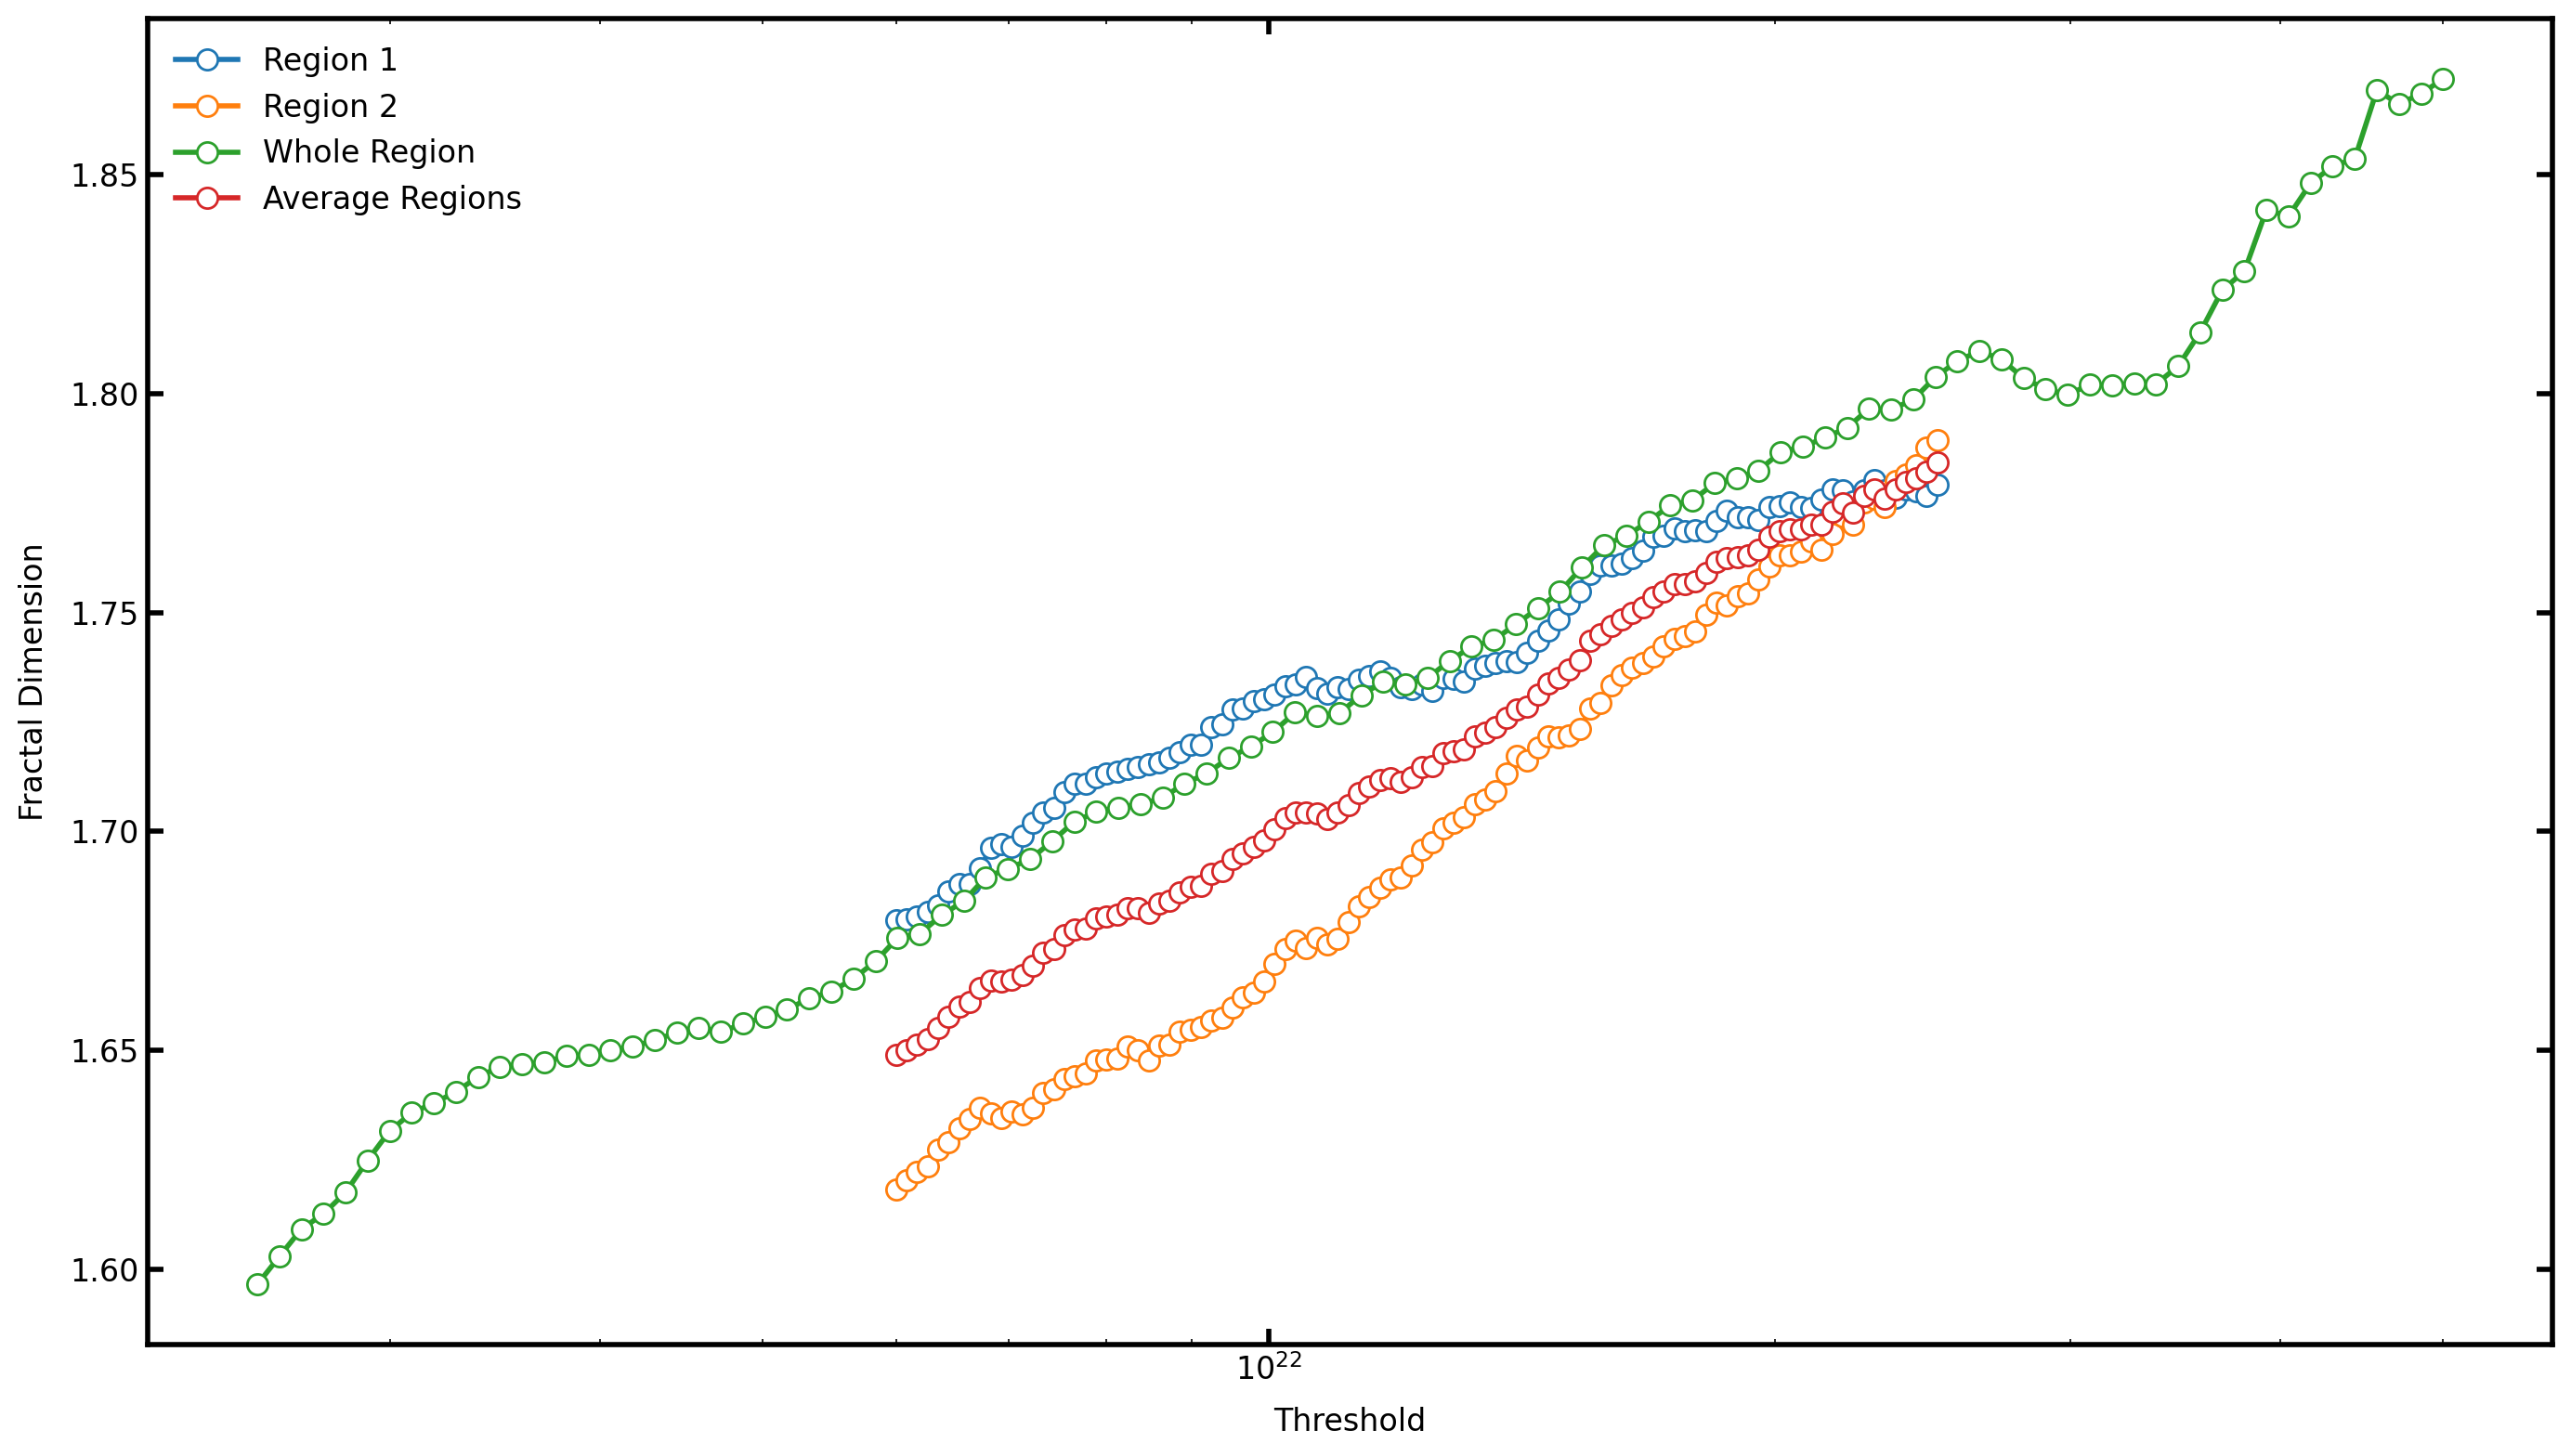

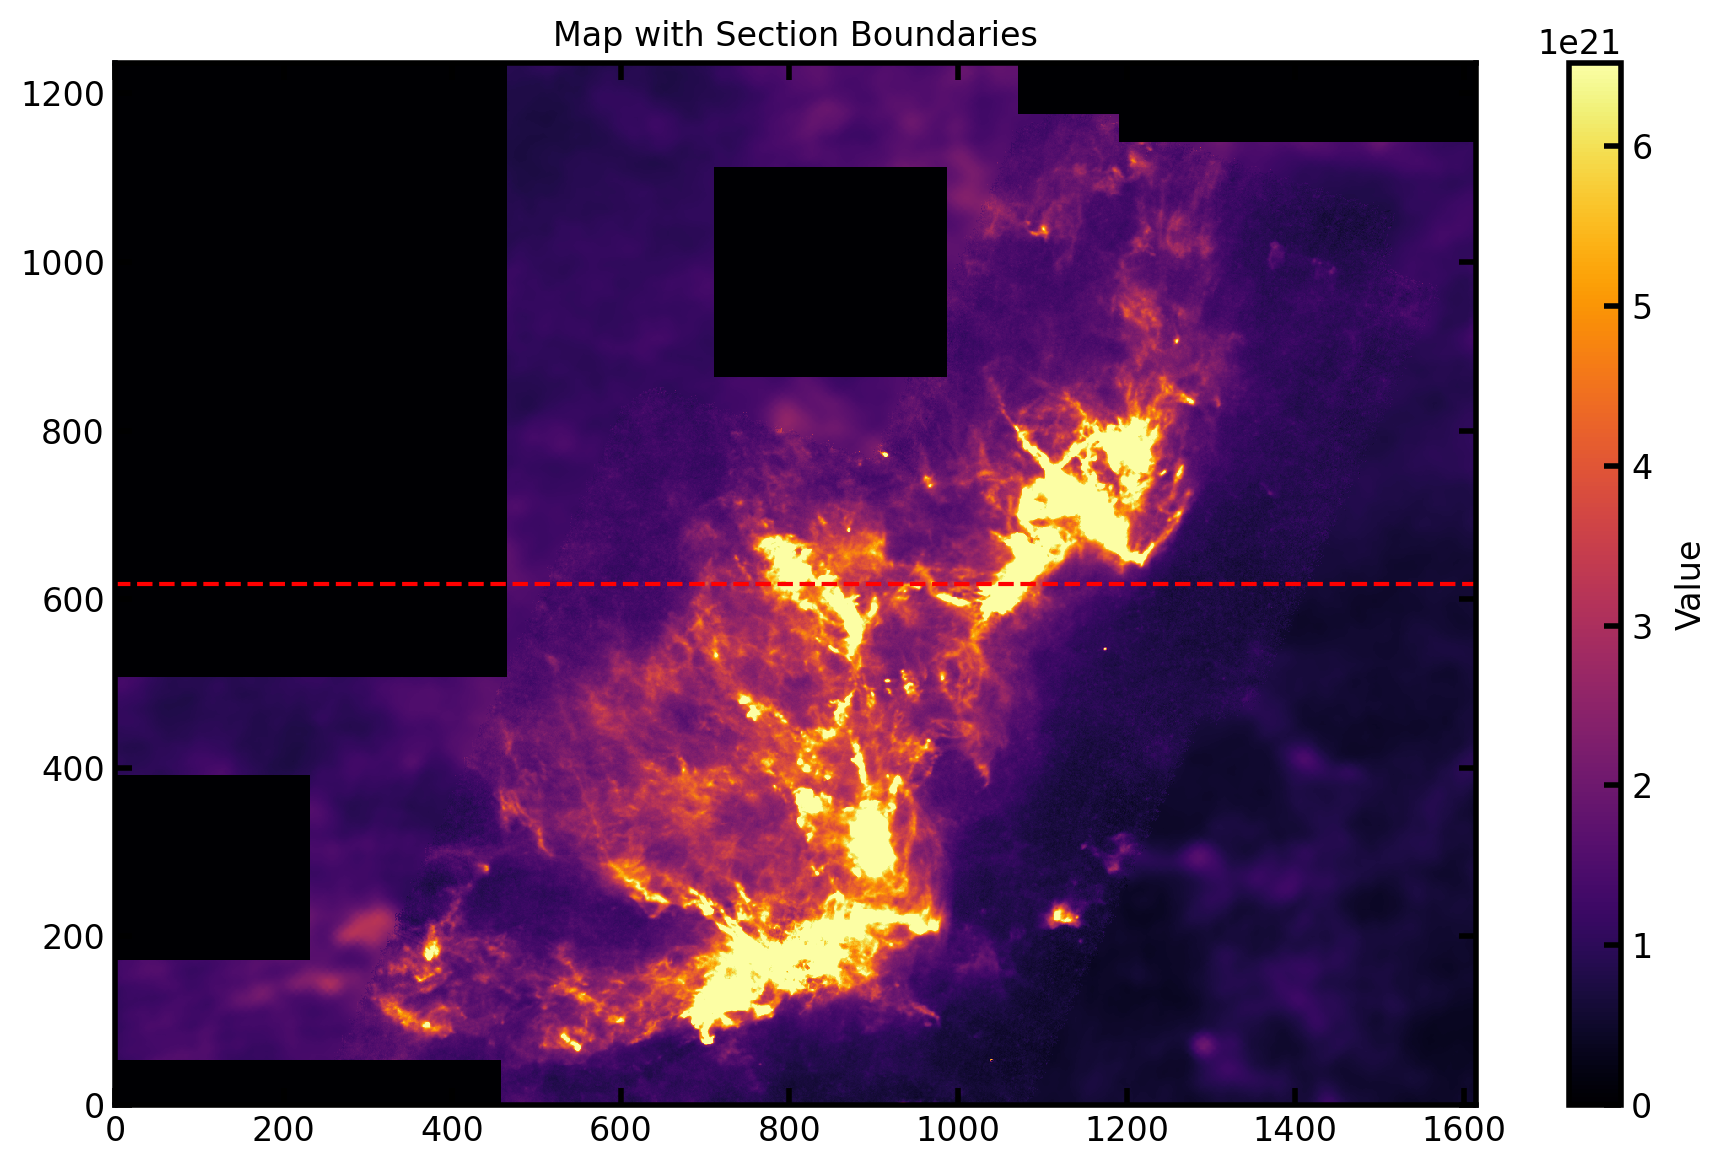

<Figure size 640x480 with 0 Axes>

In [5]:
def show_sections(data, n_regions=3):
    height, width = data.shape
    # Determine step size for slicing along the y-axis
    h_step = height // n_regions

    # Define the color limits based on percentiles
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

    min_value = np.percentile(data, 2)  # 2nd percentile
    max_value = np.percentile(data, 98)  # 98th percentile

    # Plot the entire data map
    plt.figure(figsize=(10, 6))
    plt.imshow(data, vmin=min_value, vmax=max_value, interpolation=None, origin='lower', cmap='inferno')

    # Draw vertical lines to indicate section boundaries
    for i in range(1, n_regions):
        plt.axhline(y=i * h_step, color="red", linestyle="--", linewidth=1.5)

    plt.title("Map with Section Boundaries")
    plt.colorbar(label="Value")
    plt.show()


    plt.tight_layout()
    plt.show()

def marching_minkowski_functionals(data, n_regions, region_name="Orion A", threshold_min=6e21, threshold_max=2.5e22):
    """
    Calculates the Minkowski functionals for the map divided along the y-axis.

    Parameters:
        data (ndarray): 2D array of the map data.
        region_name (str): Name of the region (for labeling purposes).
        threshold_min (float): Minimum threshold value.
        threshold_max (float): Maximum threshold value.
        n_regions (int): Number of sections to divide into along the y-axis.

    Returns:
        avg_log_areas (ndarray): Averaged log areas over all regions.
        avg_log_perimeters (ndarray): Averaged log perimeters over all regions.
    """
    thresholds = np.logspace(np.log10(threshold_min), np.log10(threshold_max), 100)

    # Get the shape of the data
    height, width = data.shape

    # Determine step size for slicing along the y-axis
    h_step = height // n_regions

    # Storage for results
    all_log_areas = []
    all_log_perimeters = []

    fractal_dimensions = []

    for i in range(n_regions):
        # Slice the region along the y-axis
        region = data[i * h_step:(i + 1) * h_step, :]

        # Store Minkowski Functional values
        areas = []
        perimeters = []

        # Process each threshold
        for threshold in thresholds:
            # Create binary mask
            mask = region >= threshold

            # Compute Area (v0)
            area = np.sum(mask)
            areas.append(area)

            # Compute Perimeter (v1)
            perim = perimeter(mask)  # Assume `perimeter` is defined elsewhere
            perimeters.append(perim)

        # Convert to log scale
        log_areas = np.log10(areas)
        log_perimeters = np.log10(perimeters)

        # Append for averaging
        all_log_areas.append(log_areas)
        all_log_perimeters.append(log_perimeters)

        fractal_dimensions.append([2*log_perimeters/log_areas])

    return fractal_dimensions, thresholds

n_regions = 2
fractal_dimensions, thresholds = marching_minkowski_functionals(N_H2_OB, n_regions)

plt.figure(figsize=(14, 8))

for i in range(0, n_regions):
    plt.plot(thresholds, fractal_dimensions[i][0], '-o', label="Region "+str(i+1))

plt.plot(thresholds_OB, fractal_dimension_OB, '-o', label="Whole Region")
plt.plot(thresholds, np.mean(fractal_dimensions, axis=0)[0], '-o', label="Average Single Regions")

plt.xlabel('Threshold')
plt.ylabel('Fractal Dimension')
plt.xscale("log")

plt.legend()
show_sections(N_H2_OB, n_regions)

### Mass and Size Relationship with the fractal dimension

In [6]:
# Convert column density maps into mass maps
pixel_scale = 0.00417
distance = 420
radians = 180/np.pi #conversion factor: rad in deg

rad_per_px = pixel_scale/radians
pc_per_px = np.sin(rad_per_px)*distance
pc2_per_px = pc_per_px**2
cm_per_pc = 3.086*10**18
cm2_per_px = pc2_per_px * (cm_per_pc ** 2) 

D = 412

m_p = 1.67e-27 # mass of proton (kg)

M_H2_OA = np.array(N_H2_OA, dtype=np.float64)*2.8*m_p/(1.98e30)
M_H2_OB = np.array(N_H2_OB, dtype=np.float64)*2.8*m_p/(1.98e30)

# M_H2 = M_H2*area # check here!
M_H2_OA = M_H2_OA * cm2_per_px
M_H2_OB = M_H2_OB * cm2_per_px

# Assuming M_H2_clean is already defined
M_H2_OA = np.nan_to_num(M_H2_OA, nan=0.0, posinf=0.0, neginf=0.0)
M_H2_OB = np.nan_to_num(M_H2_OB, nan=0.0, posinf=0.0, neginf=0.0)

# Masking out negative values
M_H2_OA = np.where(M_H2_OA > 0, M_H2_OA, 0)
M_H2_OB = np.where(M_H2_OB > 0, M_H2_OB, 0)

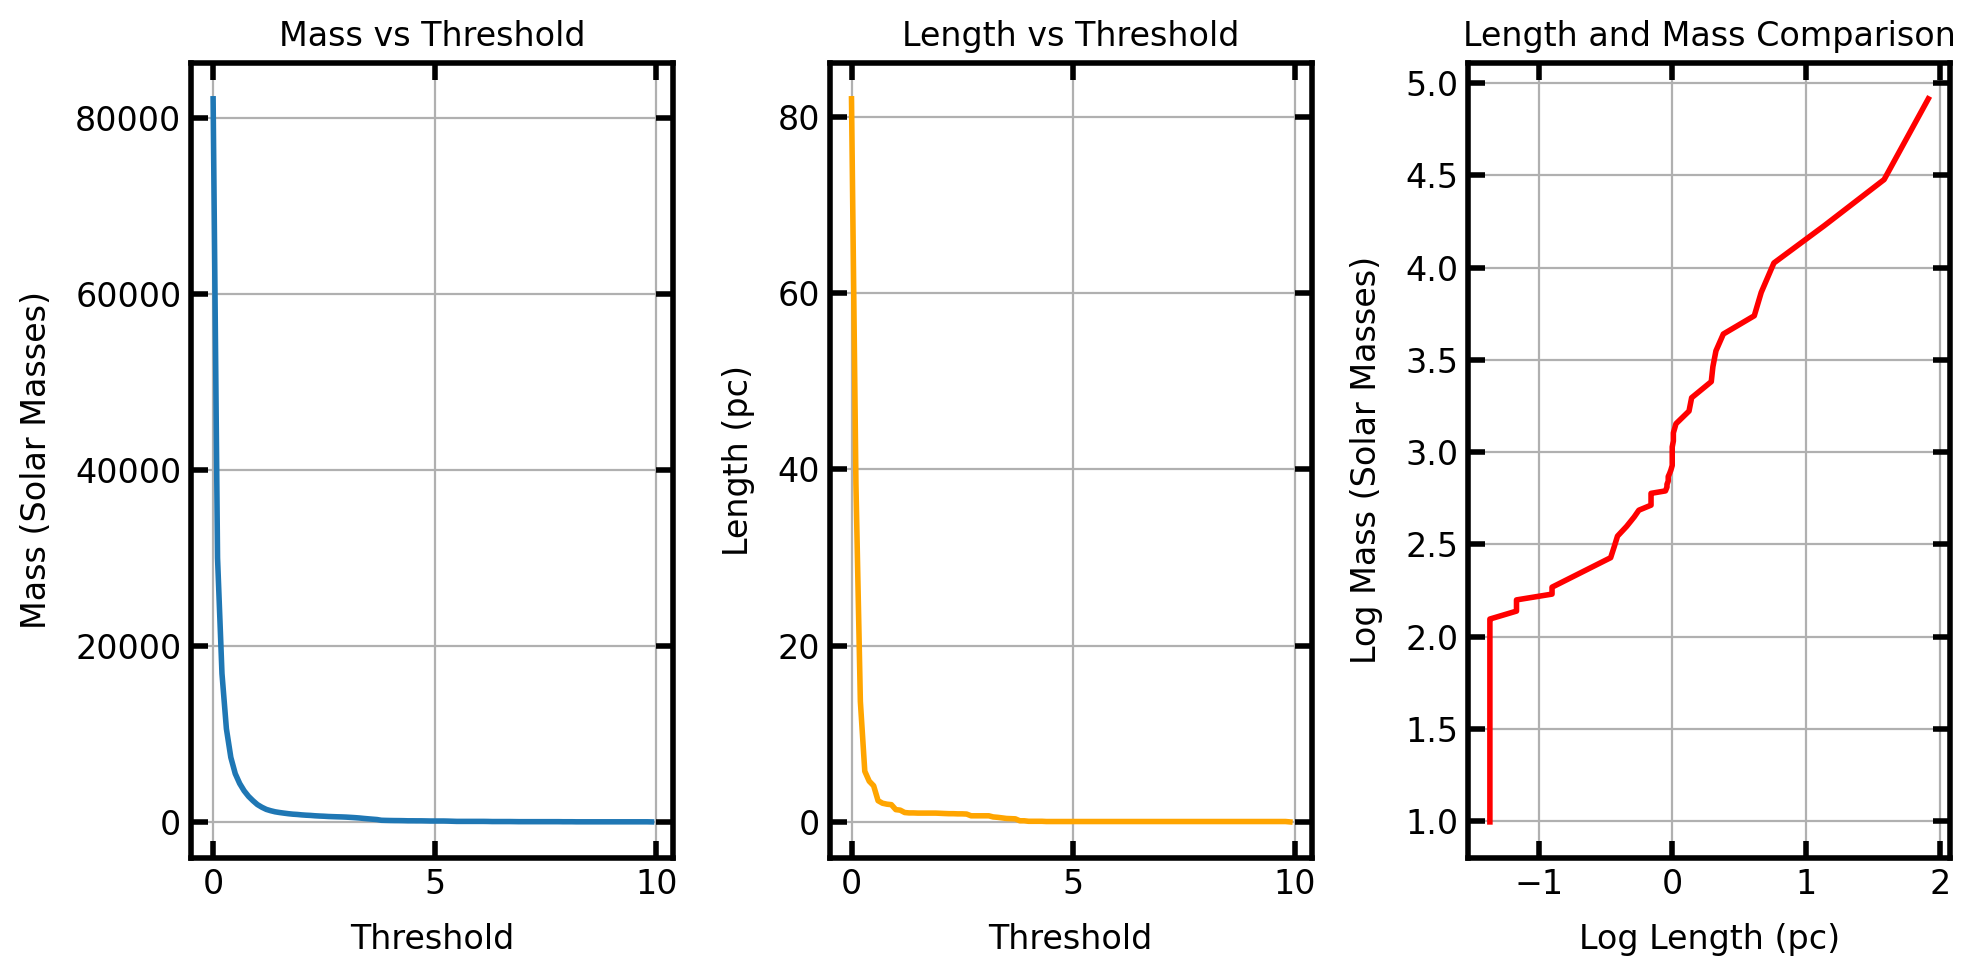

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects

mass_map = M_H2_OA 

# Define thresholds
thresholds = np.linspace(np.min(mass_map), np.max(mass_map), 100)

# Arrays to store results
masses = []
lengths = []

for threshold in thresholds:
    # Apply the threshold
    binary_map = mass_map > threshold
    
    # Calculate mass
    mass = np.sum(mass_map[binary_map])
    masses.append(mass)
    
    # Identify connected structures
    labeled_map, num_features = label(binary_map)
    
    if num_features > 0:
        # Find the largest structure
        largest_structure = max(
            find_objects(labeled_map),
            key=lambda obj: (obj[1].stop - obj[1].start) + (obj[0].stop - obj[0].start)
        )
        
        # Estimate length (diagonal distance)
        length = np.sqrt(
            (largest_structure[0].stop - largest_structure[0].start)**2 +
            (largest_structure[1].stop - largest_structure[1].start)**2
        ) * pc_per_px # Convert to pc
        lengths.append(length)
    else:
        lengths.append(0)  # No structures found

# Plot Mass vs Threshold
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.plot(thresholds, masses, label="Mass")
plt.xlabel("Threshold")
plt.ylabel("Mass (Solar Masses)")
plt.title("Mass vs Threshold")
plt.grid(True)

# Plot Length vs Threshold
plt.subplot(1, 3, 2)
plt.plot(thresholds, lengths, label="Length", color="orange")
plt.xlabel("Threshold")
plt.ylabel("Length (pc)")
plt.title("Length vs Threshold")
plt.grid(True)

# Plot Length vs Mass
plt.subplot(1, 3, 3)
plt.plot(np.log10(lengths), np.log10(masses), color="red")
plt.ylabel("Log Mass (Solar Masses)")
plt.xlabel("Log Length (pc)")
plt.title("Length and Mass Comparison")
plt.grid(True)

plt.tight_layout()
plt.show()

Mean Fractal Dimension from the Mass-Size Relation (kinda): -174.36942200209947


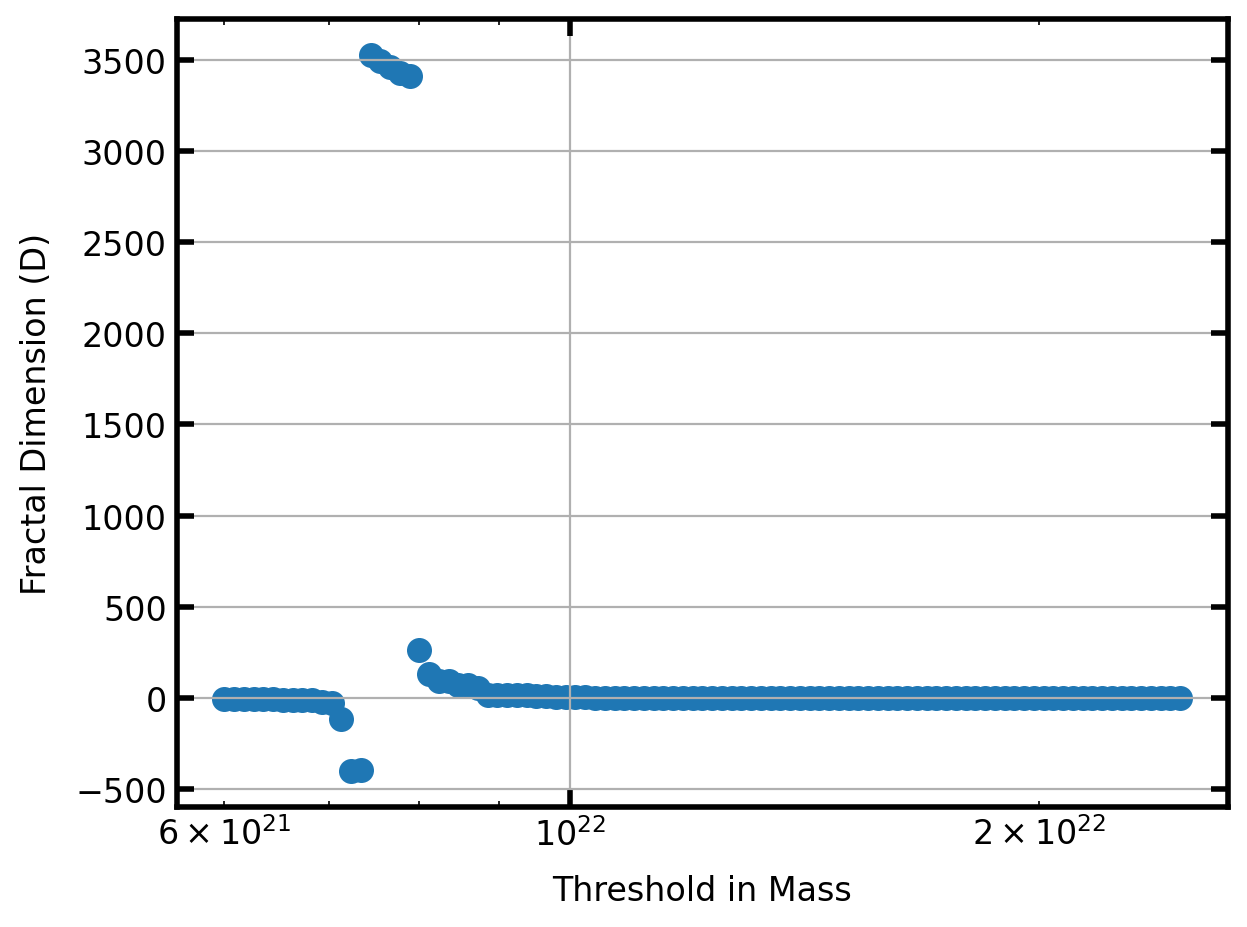

In [ ]:
log_lengths = np.log10(lengths)
log_masses = np.log10(masses)

# I think that the methodological approach is not correct here
# The mass is not directly proportional to the length (although the mass-size relation is a thing)
# Maybe -D ?

D = 2*log_lengths/log_masses # connection to Minkowski Functionals (Mandelbrot, Hack)

plt.scatter(thresholds, -D)

plt.xlabel("Threshold in Mass")
plt.ylabel("Fractal Dimension (D)")
plt.xscale("log")
plt.grid(True)

print("Mean Fractal Dimension from the Mass-Size Relation (kinda):", np.nanmean(D))

In [ ]:
# Kolmogorov turbulence predicts the fractal dimension to be 5/3 (1.7) for turbulent isobar models
# Can we see that here as well?